In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3287160, 828)
(3287160, 8)
validation
(389976, 828)
(389976, 8)
test
(483136, 828)
(483136, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/329 [..............................] - ETA: 9:59 - loss: 2.1535 - STD: 0.0491 - MAE: 0.2188

  3/329 [..............................] - ETA: 8s - loss: 2.1102 - STD: 0.0267 - MAE: 0.2188  

  6/329 [..............................] - ETA: 8s - loss: 2.1031 - STD: 0.0249 - MAE: 0.2187

  8/329 [..............................] - ETA: 8s - loss: 2.0968 - STD: 0.0208 - MAE: 0.2187

 10/329 [..............................] - ETA: 8s - loss: 2.0928 - STD: 0.0191 - MAE: 0.2186

 13/329 [>.............................] - ETA: 8s - loss: 2.0882 - STD: 0.0184 - MAE: 0.2186

 15/329 [>.............................] - ETA: 7s - loss: 2.0843 - STD: 0.0171 - MAE: 0.2185

 17/329 [>.............................] - ETA: 7s - loss: 2.0798 - STD: 0.0162 - MAE: 0.2184

 20/329 [>.............................] - ETA: 7s - loss: 2.0715 - STD: 0.0165 - MAE: 0.2181

 22/329 [=>............................] - ETA: 7s - loss: 2.0640 - STD: 0.0173 - MAE: 0.2179

 24/329 [=>............................] - ETA: 7s - loss: 2.0554 - STD: 0.0189 - MAE: 0.2175

 26/329 [=>............................] - ETA: 7s - loss: 2.0457 - STD: 0.0209 - MAE: 0.2171

 28/329 [=>............................] - ETA: 7s - loss: 2.0356 - STD: 0.0234 - MAE: 0.2166

 31/329 [=>............................] - ETA: 7s - loss: 2.0198 - STD: 0.0274 - MAE: 0.2157

 34/329 [==>...........................] - ETA: 7s - loss: 2.0038 - STD: 0.0314 - MAE: 0.2148

 37/329 [==>...........................] - ETA: 7s - loss: 1.9868 - STD: 0.0351 - MAE: 0.2139

 39/329 [==>...........................] - ETA: 7s - loss: 1.9752 - STD: 0.0376 - MAE: 0.2133

 41/329 [==>...........................] - ETA: 7s - loss: 1.9635 - STD: 0.0398 - MAE: 0.2127

 43/329 [==>...........................] - ETA: 7s - loss: 1.9511 - STD: 0.0422 - MAE: 0.2120

 45/329 [===>..........................] - ETA: 7s - loss: 1.9385 - STD: 0.0445 - MAE: 0.2113

 47/329 [===>..........................] - ETA: 7s - loss: 1.9252 - STD: 0.0469 - MAE: 0.2105

 49/329 [===>..........................] - ETA: 7s - loss: 1.9125 - STD: 0.0493 - MAE: 0.2098

 51/329 [===>..........................] - ETA: 7s - loss: 1.8992 - STD: 0.0517 - MAE: 0.2090

 53/329 [===>..........................] - ETA: 6s - loss: 1.8865 - STD: 0.0541 - MAE: 0.2082

 55/329 [====>.........................] - ETA: 6s - loss: 1.8743 - STD: 0.0564 - MAE: 0.2074

 57/329 [====>.........................] - ETA: 6s - loss: 1.8624 - STD: 0.0587 - MAE: 0.2067

 59/329 [====>.........................] - ETA: 6s - loss: 1.8506 - STD: 0.0609 - MAE: 0.2059

 61/329 [====>.........................] - ETA: 6s - loss: 1.8395 - STD: 0.0631 - MAE: 0.2051

 63/329 [====>.........................] - ETA: 6s - loss: 1.8287 - STD: 0.0652 - MAE: 0.2044

 65/329 [====>.........................] - ETA: 6s - loss: 1.8179 - STD: 0.0673 - MAE: 0.2037

 67/329 [=====>........................] - ETA: 6s - loss: 1.8075 - STD: 0.0692 - MAE: 0.2030

 69/329 [=====>........................] - ETA: 6s - loss: 1.7973 - STD: 0.0711 - MAE: 0.2023

 71/329 [=====>........................] - ETA: 6s - loss: 1.7873 - STD: 0.0729 - MAE: 0.2017

 73/329 [=====>........................] - ETA: 6s - loss: 1.7776 - STD: 0.0746 - MAE: 0.2010

 75/329 [=====>........................] - ETA: 6s - loss: 1.7682 - STD: 0.0762 - MAE: 0.2004

 77/329 [======>.......................] - ETA: 6s - loss: 1.7589 - STD: 0.0778 - MAE: 0.1998

 79/329 [======>.......................] - ETA: 6s - loss: 1.7499 - STD: 0.0794 - MAE: 0.1991

 81/329 [======>.......................] - ETA: 6s - loss: 1.7411 - STD: 0.0810 - MAE: 0.1985

 84/329 [======>.......................] - ETA: 6s - loss: 1.7284 - STD: 0.0832 - MAE: 0.1977

 86/329 [======>.......................] - ETA: 6s - loss: 1.7205 - STD: 0.0847 - MAE: 0.1971

 88/329 [=======>......................] - ETA: 6s - loss: 1.7125 - STD: 0.0861 - MAE: 0.1965

 90/329 [=======>......................] - ETA: 6s - loss: 1.7048 - STD: 0.0875 - MAE: 0.1959

 92/329 [=======>......................] - ETA: 6s - loss: 1.6976 - STD: 0.0888 - MAE: 0.1954

 94/329 [=======>......................] - ETA: 6s - loss: 1.6904 - STD: 0.0902 - MAE: 0.1949

 96/329 [=======>......................] - ETA: 5s - loss: 1.6835 - STD: 0.0914 - MAE: 0.1944

 98/329 [=======>......................] - ETA: 5s - loss: 1.6770 - STD: 0.0927 - MAE: 0.1939

100/329 [========>.....................] - ETA: 5s - loss: 1.6708 - STD: 0.0939 - MAE: 0.1934

102/329 [========>.....................] - ETA: 5s - loss: 1.6645 - STD: 0.0951 - MAE: 0.1929

104/329 [========>.....................] - ETA: 5s - loss: 1.6585 - STD: 0.0962 - MAE: 0.1925

106/329 [========>.....................] - ETA: 5s - loss: 1.6527 - STD: 0.0973 - MAE: 0.1920

108/329 [========>.....................] - ETA: 5s - loss: 1.6470 - STD: 0.0983 - MAE: 0.1916

110/329 [=========>....................] - ETA: 5s - loss: 1.6413 - STD: 0.0994 - MAE: 0.1911

112/329 [=========>....................] - ETA: 5s - loss: 1.6357 - STD: 0.1004 - MAE: 0.1907

114/329 [=========>....................] - ETA: 5s - loss: 1.6302 - STD: 0.1014 - MAE: 0.1903

116/329 [=========>....................] - ETA: 5s - loss: 1.6251 - STD: 0.1024 - MAE: 0.1899

118/329 [=========>....................] - ETA: 5s - loss: 1.6201 - STD: 0.1033 - MAE: 0.1895

120/329 [=========>....................] - ETA: 5s - loss: 1.6153 - STD: 0.1043 - MAE: 0.1891

123/329 [==========>...................] - ETA: 5s - loss: 1.6081 - STD: 0.1056 - MAE: 0.1886

125/329 [==========>...................] - ETA: 5s - loss: 1.6034 - STD: 0.1065 - MAE: 0.1882

127/329 [==========>...................] - ETA: 5s - loss: 1.5989 - STD: 0.1073 - MAE: 0.1878

129/329 [==========>...................] - ETA: 5s - loss: 1.5945 - STD: 0.1081 - MAE: 0.1875

131/329 [==========>...................] - ETA: 5s - loss: 1.5900 - STD: 0.1090 - MAE: 0.1871

134/329 [===========>..................] - ETA: 4s - loss: 1.5837 - STD: 0.1101 - MAE: 0.1866

137/329 [===========>..................] - ETA: 4s - loss: 1.5775 - STD: 0.1112 - MAE: 0.1861

140/329 [===========>..................] - ETA: 4s - loss: 1.5715 - STD: 0.1123 - MAE: 0.1857

142/329 [===========>..................] - ETA: 4s - loss: 1.5676 - STD: 0.1130 - MAE: 0.1854

144/329 [============>.................] - ETA: 4s - loss: 1.5638 - STD: 0.1138 - MAE: 0.1851

146/329 [============>.................] - ETA: 4s - loss: 1.5600 - STD: 0.1144 - MAE: 0.1847

148/329 [============>.................] - ETA: 4s - loss: 1.5563 - STD: 0.1151 - MAE: 0.1845

150/329 [============>.................] - ETA: 4s - loss: 1.5527 - STD: 0.1158 - MAE: 0.1842

152/329 [============>.................] - ETA: 4s - loss: 1.5491 - STD: 0.1164 - MAE: 0.1839

154/329 [=============>................] - ETA: 4s - loss: 1.5456 - STD: 0.1170 - MAE: 0.1836

156/329 [=============>................] - ETA: 4s - loss: 1.5422 - STD: 0.1176 - MAE: 0.1833

158/329 [=============>................] - ETA: 4s - loss: 1.5387 - STD: 0.1182 - MAE: 0.1831

160/329 [=============>................] - ETA: 4s - loss: 1.5354 - STD: 0.1188 - MAE: 0.1828

162/329 [=============>................] - ETA: 4s - loss: 1.5321 - STD: 0.1194 - MAE: 0.1825

164/329 [=============>................] - ETA: 4s - loss: 1.5288 - STD: 0.1200 - MAE: 0.1823

166/329 [==============>...............] - ETA: 4s - loss: 1.5257 - STD: 0.1206 - MAE: 0.1820

168/329 [==============>...............] - ETA: 4s - loss: 1.5225 - STD: 0.1211 - MAE: 0.1817

170/329 [==============>...............] - ETA: 4s - loss: 1.5194 - STD: 0.1217 - MAE: 0.1815

172/329 [==============>...............] - ETA: 4s - loss: 1.5163 - STD: 0.1222 - MAE: 0.1812

174/329 [==============>...............] - ETA: 3s - loss: 1.5133 - STD: 0.1227 - MAE: 0.1810

176/329 [===============>..............] - ETA: 3s - loss: 1.5104 - STD: 0.1233 - MAE: 0.1807

178/329 [===============>..............] - ETA: 3s - loss: 1.5074 - STD: 0.1238 - MAE: 0.1805

180/329 [===============>..............] - ETA: 3s - loss: 1.5045 - STD: 0.1243 - MAE: 0.1803

182/329 [===============>..............] - ETA: 3s - loss: 1.5016 - STD: 0.1248 - MAE: 0.1800

184/329 [===============>..............] - ETA: 3s - loss: 1.4989 - STD: 0.1253 - MAE: 0.1798

186/329 [===============>..............] - ETA: 3s - loss: 1.4965 - STD: 0.1258 - MAE: 0.1796

188/329 [================>.............] - ETA: 3s - loss: 1.4938 - STD: 0.1263 - MAE: 0.1793

190/329 [================>.............] - ETA: 3s - loss: 1.4912 - STD: 0.1268 - MAE: 0.1791

192/329 [================>.............] - ETA: 3s - loss: 1.4887 - STD: 0.1272 - MAE: 0.1789

194/329 [================>.............] - ETA: 3s - loss: 1.4860 - STD: 0.1277 - MAE: 0.1787

196/329 [================>.............] - ETA: 3s - loss: 1.4835 - STD: 0.1281 - MAE: 0.1785

198/329 [=================>............] - ETA: 3s - loss: 1.4811 - STD: 0.1286 - MAE: 0.1783

200/329 [=================>............] - ETA: 3s - loss: 1.4787 - STD: 0.1290 - MAE: 0.1781

202/329 [=================>............] - ETA: 3s - loss: 1.4763 - STD: 0.1295 - MAE: 0.1779

204/329 [=================>............] - ETA: 3s - loss: 1.4737 - STD: 0.1299 - MAE: 0.1776

206/329 [=================>............] - ETA: 3s - loss: 1.4712 - STD: 0.1303 - MAE: 0.1774

208/329 [=================>............] - ETA: 3s - loss: 1.4688 - STD: 0.1307 - MAE: 0.1772

210/329 [==================>...........] - ETA: 3s - loss: 1.4664 - STD: 0.1312 - MAE: 0.1770

212/329 [==================>...........] - ETA: 3s - loss: 1.4640 - STD: 0.1316 - MAE: 0.1768

214/329 [==================>...........] - ETA: 2s - loss: 1.4618 - STD: 0.1320 - MAE: 0.1766

216/329 [==================>...........] - ETA: 2s - loss: 1.4593 - STD: 0.1324 - MAE: 0.1764

218/329 [==================>...........] - ETA: 2s - loss: 1.4571 - STD: 0.1328 - MAE: 0.1762

220/329 [===================>..........] - ETA: 2s - loss: 1.4549 - STD: 0.1332 - MAE: 0.1760

222/329 [===================>..........] - ETA: 2s - loss: 1.4527 - STD: 0.1336 - MAE: 0.1758

225/329 [===================>..........] - ETA: 2s - loss: 1.4496 - STD: 0.1342 - MAE: 0.1756

228/329 [===================>..........] - ETA: 2s - loss: 1.4463 - STD: 0.1347 - MAE: 0.1753

230/329 [===================>..........] - ETA: 2s - loss: 1.4442 - STD: 0.1351 - MAE: 0.1751

232/329 [====================>.........] - ETA: 2s - loss: 1.4421 - STD: 0.1354 - MAE: 0.1749

234/329 [====================>.........] - ETA: 2s - loss: 1.4401 - STD: 0.1358 - MAE: 0.1748

237/329 [====================>.........] - ETA: 2s - loss: 1.4371 - STD: 0.1363 - MAE: 0.1745

239/329 [====================>.........] - ETA: 2s - loss: 1.4352 - STD: 0.1367 - MAE: 0.1743

241/329 [====================>.........] - ETA: 2s - loss: 1.4334 - STD: 0.1370 - MAE: 0.1742

243/329 [=====================>........] - ETA: 2s - loss: 1.4315 - STD: 0.1374 - MAE: 0.1740

246/329 [=====================>........] - ETA: 2s - loss: 1.4287 - STD: 0.1379 - MAE: 0.1737

248/329 [=====================>........] - ETA: 2s - loss: 1.4268 - STD: 0.1382 - MAE: 0.1736

250/329 [=====================>........] - ETA: 2s - loss: 1.4250 - STD: 0.1386 - MAE: 0.1734

252/329 [=====================>........] - ETA: 1s - loss: 1.4232 - STD: 0.1389 - MAE: 0.1732

255/329 [======================>.......] - ETA: 1s - loss: 1.4205 - STD: 0.1394 - MAE: 0.1730

257/329 [======================>.......] - ETA: 1s - loss: 1.4188 - STD: 0.1397 - MAE: 0.1728

259/329 [======================>.......] - ETA: 1s - loss: 1.4171 - STD: 0.1400 - MAE: 0.1727

261/329 [======================>.......] - ETA: 1s - loss: 1.4154 - STD: 0.1403 - MAE: 0.1725

263/329 [======================>.......] - ETA: 1s - loss: 1.4136 - STD: 0.1406 - MAE: 0.1724

265/329 [=======================>......] - ETA: 1s - loss: 1.4118 - STD: 0.1409 - MAE: 0.1722

267/329 [=======================>......] - ETA: 1s - loss: 1.4102 - STD: 0.1412 - MAE: 0.1721

270/329 [=======================>......] - ETA: 1s - loss: 1.4077 - STD: 0.1417 - MAE: 0.1718

273/329 [=======================>......] - ETA: 1s - loss: 1.4051 - STD: 0.1421 - MAE: 0.1716

275/329 [========================>.....] - ETA: 1s - loss: 1.4034 - STD: 0.1424 - MAE: 0.1715

278/329 [========================>.....] - ETA: 1s - loss: 1.4008 - STD: 0.1429 - MAE: 0.1712

280/329 [========================>.....] - ETA: 1s - loss: 1.3992 - STD: 0.1431 - MAE: 0.1711

283/329 [========================>.....] - ETA: 1s - loss: 1.3966 - STD: 0.1436 - MAE: 0.1709

284/329 [========================>.....] - ETA: 1s - loss: 1.3961 - STD: 0.1437 - MAE: 0.1708

287/329 [=========================>....] - ETA: 1s - loss: 1.3936 - STD: 0.1441 - MAE: 0.1706

289/329 [=========================>....] - ETA: 1s - loss: 1.3919 - STD: 0.1444 - MAE: 0.1704

291/329 [=========================>....] - ETA: 1s - loss: 1.3903 - STD: 0.1447 - MAE: 0.1703

294/329 [=========================>....] - ETA: 1s - loss: 1.3880 - STD: 0.1451 - MAE: 0.1701

297/329 [==========================>...] - ETA: 0s - loss: 1.3857 - STD: 0.1455 - MAE: 0.1699

300/329 [==========================>...] - ETA: 0s - loss: 1.3835 - STD: 0.1459 - MAE: 0.1697

303/329 [==========================>...] - ETA: 0s - loss: 1.3814 - STD: 0.1462 - MAE: 0.1695

306/329 [==========================>...] - ETA: 0s - loss: 1.3792 - STD: 0.1466 - MAE: 0.1693

309/329 [===========================>..] - ETA: 0s - loss: 1.3772 - STD: 0.1470 - MAE: 0.1691

312/329 [===========================>..] - ETA: 0s - loss: 1.3753 - STD: 0.1474 - MAE: 0.1689

315/329 [===========================>..] - ETA: 0s - loss: 1.3732 - STD: 0.1477 - MAE: 0.1687

318/329 [===========================>..] - ETA: 0s - loss: 1.3711 - STD: 0.1481 - MAE: 0.1685

321/329 [============================>.] - ETA: 0s - loss: 1.3690 - STD: 0.1484 - MAE: 0.1683

324/329 [============================>.] - ETA: 0s - loss: 1.3669 - STD: 0.1488 - MAE: 0.1681

327/329 [============================>.] - ETA: 0s - loss: 1.3648 - STD: 0.1491 - MAE: 0.1679

329/329 [==============================] - 13s 33ms/step - loss: 1.3634 - STD: 0.1493 - MAE: 0.1678 - val_loss: 1.2190 - val_STD: 0.1871 - val_MAE: 0.1477


Epoch 2/10000


  1/329 [..............................] - ETA: 15s - loss: 1.1193 - STD: 0.1867 - MAE: 0.1461

  4/329 [..............................] - ETA: 7s - loss: 1.1268 - STD: 0.1868 - MAE: 0.1465 

  7/329 [..............................] - ETA: 7s - loss: 1.1273 - STD: 0.1864 - MAE: 0.1468

 10/329 [..............................] - ETA: 7s - loss: 1.1277 - STD: 0.1866 - MAE: 0.1468

 13/329 [>.............................] - ETA: 7s - loss: 1.1262 - STD: 0.1871 - MAE: 0.1465

 16/329 [>.............................] - ETA: 7s - loss: 1.1259 - STD: 0.1873 - MAE: 0.1464

 19/329 [>.............................] - ETA: 7s - loss: 1.1241 - STD: 0.1875 - MAE: 0.1463

 22/329 [=>............................] - ETA: 7s - loss: 1.1235 - STD: 0.1878 - MAE: 0.1461

 25/329 [=>............................] - ETA: 6s - loss: 1.1236 - STD: 0.1881 - MAE: 0.1460

 28/329 [=>............................] - ETA: 6s - loss: 1.1233 - STD: 0.1882 - MAE: 0.1459

 31/329 [=>............................] - ETA: 6s - loss: 1.1227 - STD: 0.1884 - MAE: 0.1458

 34/329 [==>...........................] - ETA: 6s - loss: 1.1245 - STD: 0.1885 - MAE: 0.1459

 37/329 [==>...........................] - ETA: 6s - loss: 1.1247 - STD: 0.1886 - MAE: 0.1459

 40/329 [==>...........................] - ETA: 6s - loss: 1.1259 - STD: 0.1886 - MAE: 0.1459

 43/329 [==>...........................] - ETA: 6s - loss: 1.1264 - STD: 0.1887 - MAE: 0.1459

 46/329 [===>..........................] - ETA: 6s - loss: 1.1259 - STD: 0.1888 - MAE: 0.1458

 49/329 [===>..........................] - ETA: 6s - loss: 1.1261 - STD: 0.1889 - MAE: 0.1458

 52/329 [===>..........................] - ETA: 6s - loss: 1.1265 - STD: 0.1889 - MAE: 0.1458

 55/329 [====>.........................] - ETA: 6s - loss: 1.1274 - STD: 0.1890 - MAE: 0.1458

 58/329 [====>.........................] - ETA: 6s - loss: 1.1280 - STD: 0.1891 - MAE: 0.1458

 61/329 [====>.........................] - ETA: 6s - loss: 1.1276 - STD: 0.1892 - MAE: 0.1457

 64/329 [====>.........................] - ETA: 6s - loss: 1.1272 - STD: 0.1892 - MAE: 0.1457

 67/329 [=====>........................] - ETA: 5s - loss: 1.1261 - STD: 0.1893 - MAE: 0.1456

 70/329 [=====>........................] - ETA: 5s - loss: 1.1255 - STD: 0.1893 - MAE: 0.1455

 73/329 [=====>........................] - ETA: 5s - loss: 1.1250 - STD: 0.1894 - MAE: 0.1455

 76/329 [=====>........................] - ETA: 5s - loss: 1.1241 - STD: 0.1894 - MAE: 0.1454

 79/329 [======>.......................] - ETA: 5s - loss: 1.1233 - STD: 0.1895 - MAE: 0.1453

 82/329 [======>.......................] - ETA: 5s - loss: 1.1227 - STD: 0.1896 - MAE: 0.1453

 85/329 [======>.......................] - ETA: 5s - loss: 1.1214 - STD: 0.1897 - MAE: 0.1452

 88/329 [=======>......................] - ETA: 5s - loss: 1.1206 - STD: 0.1898 - MAE: 0.1451

 91/329 [=======>......................] - ETA: 5s - loss: 1.1198 - STD: 0.1899 - MAE: 0.1450

 94/329 [=======>......................] - ETA: 5s - loss: 1.1190 - STD: 0.1900 - MAE: 0.1449

 97/329 [=======>......................] - ETA: 5s - loss: 1.1182 - STD: 0.1901 - MAE: 0.1448

100/329 [========>.....................] - ETA: 5s - loss: 1.1171 - STD: 0.1902 - MAE: 0.1448

103/329 [========>.....................] - ETA: 5s - loss: 1.1163 - STD: 0.1903 - MAE: 0.1447

106/329 [========>.....................] - ETA: 5s - loss: 1.1158 - STD: 0.1904 - MAE: 0.1446

109/329 [========>.....................] - ETA: 4s - loss: 1.1151 - STD: 0.1905 - MAE: 0.1445

112/329 [=========>....................] - ETA: 4s - loss: 1.1147 - STD: 0.1907 - MAE: 0.1444

115/329 [=========>....................] - ETA: 4s - loss: 1.1141 - STD: 0.1907 - MAE: 0.1444

118/329 [=========>....................] - ETA: 4s - loss: 1.1135 - STD: 0.1908 - MAE: 0.1443

121/329 [==========>...................] - ETA: 4s - loss: 1.1134 - STD: 0.1909 - MAE: 0.1443

124/329 [==========>...................] - ETA: 4s - loss: 1.1124 - STD: 0.1910 - MAE: 0.1442

127/329 [==========>...................] - ETA: 4s - loss: 1.1115 - STD: 0.1912 - MAE: 0.1441

130/329 [==========>...................] - ETA: 4s - loss: 1.1107 - STD: 0.1913 - MAE: 0.1440

133/329 [===========>..................] - ETA: 4s - loss: 1.1099 - STD: 0.1914 - MAE: 0.1439

136/329 [===========>..................] - ETA: 4s - loss: 1.1090 - STD: 0.1915 - MAE: 0.1438

139/329 [===========>..................] - ETA: 4s - loss: 1.1082 - STD: 0.1916 - MAE: 0.1437

142/329 [===========>..................] - ETA: 4s - loss: 1.1075 - STD: 0.1916 - MAE: 0.1437

144/329 [============>.................] - ETA: 4s - loss: 1.1070 - STD: 0.1917 - MAE: 0.1436

147/329 [============>.................] - ETA: 4s - loss: 1.1061 - STD: 0.1918 - MAE: 0.1435

150/329 [============>.................] - ETA: 4s - loss: 1.1053 - STD: 0.1919 - MAE: 0.1435

153/329 [============>.................] - ETA: 3s - loss: 1.1046 - STD: 0.1920 - MAE: 0.1434

156/329 [=============>................] - ETA: 3s - loss: 1.1036 - STD: 0.1921 - MAE: 0.1433

159/329 [=============>................] - ETA: 3s - loss: 1.1028 - STD: 0.1922 - MAE: 0.1432

162/329 [=============>................] - ETA: 3s - loss: 1.1022 - STD: 0.1922 - MAE: 0.1431

165/329 [==============>...............] - ETA: 3s - loss: 1.1015 - STD: 0.1924 - MAE: 0.1431

168/329 [==============>...............] - ETA: 3s - loss: 1.1007 - STD: 0.1925 - MAE: 0.1430

171/329 [==============>...............] - ETA: 3s - loss: 1.0999 - STD: 0.1926 - MAE: 0.1429

174/329 [==============>...............] - ETA: 3s - loss: 1.0996 - STD: 0.1926 - MAE: 0.1428

177/329 [===============>..............] - ETA: 3s - loss: 1.0989 - STD: 0.1927 - MAE: 0.1428

180/329 [===============>..............] - ETA: 3s - loss: 1.0985 - STD: 0.1929 - MAE: 0.1427

183/329 [===============>..............] - ETA: 3s - loss: 1.0980 - STD: 0.1929 - MAE: 0.1427

186/329 [===============>..............] - ETA: 3s - loss: 1.0972 - STD: 0.1930 - MAE: 0.1426

189/329 [================>.............] - ETA: 3s - loss: 1.0965 - STD: 0.1931 - MAE: 0.1425

192/329 [================>.............] - ETA: 3s - loss: 1.0961 - STD: 0.1932 - MAE: 0.1424

195/329 [================>.............] - ETA: 3s - loss: 1.0954 - STD: 0.1933 - MAE: 0.1424

198/329 [=================>............] - ETA: 2s - loss: 1.0948 - STD: 0.1934 - MAE: 0.1423

201/329 [=================>............] - ETA: 2s - loss: 1.0942 - STD: 0.1935 - MAE: 0.1422

204/329 [=================>............] - ETA: 2s - loss: 1.0935 - STD: 0.1936 - MAE: 0.1422

207/329 [=================>............] - ETA: 2s - loss: 1.0926 - STD: 0.1937 - MAE: 0.1421

210/329 [==================>...........] - ETA: 2s - loss: 1.0919 - STD: 0.1938 - MAE: 0.1420

213/329 [==================>...........] - ETA: 2s - loss: 1.0912 - STD: 0.1938 - MAE: 0.1419

216/329 [==================>...........] - ETA: 2s - loss: 1.0905 - STD: 0.1939 - MAE: 0.1418

219/329 [==================>...........] - ETA: 2s - loss: 1.0898 - STD: 0.1940 - MAE: 0.1418

222/329 [===================>..........] - ETA: 2s - loss: 1.0890 - STD: 0.1941 - MAE: 0.1417

225/329 [===================>..........] - ETA: 2s - loss: 1.0886 - STD: 0.1942 - MAE: 0.1416

228/329 [===================>..........] - ETA: 2s - loss: 1.0879 - STD: 0.1943 - MAE: 0.1416

231/329 [====================>.........] - ETA: 2s - loss: 1.0875 - STD: 0.1944 - MAE: 0.1415

234/329 [====================>.........] - ETA: 2s - loss: 1.0868 - STD: 0.1945 - MAE: 0.1414

237/329 [====================>.........] - ETA: 2s - loss: 1.0864 - STD: 0.1945 - MAE: 0.1414

240/329 [====================>.........] - ETA: 2s - loss: 1.0857 - STD: 0.1946 - MAE: 0.1413

243/329 [=====================>........] - ETA: 1s - loss: 1.0853 - STD: 0.1947 - MAE: 0.1412

246/329 [=====================>........] - ETA: 1s - loss: 1.0846 - STD: 0.1948 - MAE: 0.1411

249/329 [=====================>........] - ETA: 1s - loss: 1.0842 - STD: 0.1949 - MAE: 0.1411

252/329 [=====================>........] - ETA: 1s - loss: 1.0838 - STD: 0.1950 - MAE: 0.1410

255/329 [======================>.......] - ETA: 1s - loss: 1.0834 - STD: 0.1951 - MAE: 0.1410

258/329 [======================>.......] - ETA: 1s - loss: 1.0829 - STD: 0.1952 - MAE: 0.1409

261/329 [======================>.......] - ETA: 1s - loss: 1.0822 - STD: 0.1952 - MAE: 0.1409

264/329 [=======================>......] - ETA: 1s - loss: 1.0816 - STD: 0.1953 - MAE: 0.1408

267/329 [=======================>......] - ETA: 1s - loss: 1.0810 - STD: 0.1954 - MAE: 0.1407

270/329 [=======================>......] - ETA: 1s - loss: 1.0804 - STD: 0.1955 - MAE: 0.1407

273/329 [=======================>......] - ETA: 1s - loss: 1.0798 - STD: 0.1955 - MAE: 0.1406

276/329 [========================>.....] - ETA: 1s - loss: 1.0793 - STD: 0.1956 - MAE: 0.1405

279/329 [========================>.....] - ETA: 1s - loss: 1.0787 - STD: 0.1957 - MAE: 0.1405

282/329 [========================>.....] - ETA: 1s - loss: 1.0781 - STD: 0.1958 - MAE: 0.1404

285/329 [========================>.....] - ETA: 0s - loss: 1.0775 - STD: 0.1958 - MAE: 0.1403

288/329 [=========================>....] - ETA: 0s - loss: 1.0768 - STD: 0.1959 - MAE: 0.1403

291/329 [=========================>....] - ETA: 0s - loss: 1.0762 - STD: 0.1960 - MAE: 0.1402

294/329 [=========================>....] - ETA: 0s - loss: 1.0758 - STD: 0.1961 - MAE: 0.1402

297/329 [==========================>...] - ETA: 0s - loss: 1.0752 - STD: 0.1962 - MAE: 0.1401

300/329 [==========================>...] - ETA: 0s - loss: 1.0747 - STD: 0.1963 - MAE: 0.1400

303/329 [==========================>...] - ETA: 0s - loss: 1.0743 - STD: 0.1964 - MAE: 0.1400

306/329 [==========================>...] - ETA: 0s - loss: 1.0739 - STD: 0.1964 - MAE: 0.1399

309/329 [===========================>..] - ETA: 0s - loss: 1.0734 - STD: 0.1965 - MAE: 0.1399

312/329 [===========================>..] - ETA: 0s - loss: 1.0729 - STD: 0.1966 - MAE: 0.1398

315/329 [===========================>..] - ETA: 0s - loss: 1.0723 - STD: 0.1966 - MAE: 0.1397

318/329 [===========================>..] - ETA: 0s - loss: 1.0717 - STD: 0.1967 - MAE: 0.1397

321/329 [============================>.] - ETA: 0s - loss: 1.0713 - STD: 0.1968 - MAE: 0.1396

324/329 [============================>.] - ETA: 0s - loss: 1.0707 - STD: 0.1969 - MAE: 0.1396

327/329 [============================>.] - ETA: 0s - loss: 1.0703 - STD: 0.1969 - MAE: 0.1395

329/329 [==============================] - 8s 25ms/step - loss: 1.0700 - STD: 0.1970 - MAE: 0.1395 - val_loss: 1.1103 - val_STD: 0.2045 - val_MAE: 0.1358


Epoch 3/10000


  1/329 [..............................] - ETA: 16s - loss: 1.0081 - STD: 0.2054 - MAE: 0.1325

  4/329 [..............................] - ETA: 7s - loss: 1.0068 - STD: 0.2052 - MAE: 0.1326 

  7/329 [..............................] - ETA: 7s - loss: 1.0099 - STD: 0.2052 - MAE: 0.1328

 10/329 [..............................] - ETA: 7s - loss: 1.0053 - STD: 0.2052 - MAE: 0.1325

 13/329 [>.............................] - ETA: 7s - loss: 1.0097 - STD: 0.2053 - MAE: 0.1328

 16/329 [>.............................] - ETA: 7s - loss: 1.0132 - STD: 0.2055 - MAE: 0.1329

 19/329 [>.............................] - ETA: 7s - loss: 1.0156 - STD: 0.2056 - MAE: 0.1330

 22/329 [=>............................] - ETA: 7s - loss: 1.0160 - STD: 0.2056 - MAE: 0.1330

 25/329 [=>............................] - ETA: 6s - loss: 1.0179 - STD: 0.2056 - MAE: 0.1331

 28/329 [=>............................] - ETA: 6s - loss: 1.0169 - STD: 0.2056 - MAE: 0.1331

 31/329 [=>............................] - ETA: 6s - loss: 1.0188 - STD: 0.2056 - MAE: 0.1332

 34/329 [==>...........................] - ETA: 6s - loss: 1.0178 - STD: 0.2057 - MAE: 0.1331

 37/329 [==>...........................] - ETA: 6s - loss: 1.0174 - STD: 0.2057 - MAE: 0.1331

 40/329 [==>...........................] - ETA: 6s - loss: 1.0165 - STD: 0.2057 - MAE: 0.1330

 43/329 [==>...........................] - ETA: 6s - loss: 1.0154 - STD: 0.2057 - MAE: 0.1329

 46/329 [===>..........................] - ETA: 6s - loss: 1.0153 - STD: 0.2057 - MAE: 0.1329

 49/329 [===>..........................] - ETA: 6s - loss: 1.0150 - STD: 0.2057 - MAE: 0.1329

 52/329 [===>..........................] - ETA: 6s - loss: 1.0146 - STD: 0.2057 - MAE: 0.1329

 55/329 [====>.........................] - ETA: 6s - loss: 1.0136 - STD: 0.2057 - MAE: 0.1328

 58/329 [====>.........................] - ETA: 6s - loss: 1.0124 - STD: 0.2058 - MAE: 0.1327

 61/329 [====>.........................] - ETA: 6s - loss: 1.0122 - STD: 0.2058 - MAE: 0.1327

 64/329 [====>.........................] - ETA: 6s - loss: 1.0124 - STD: 0.2059 - MAE: 0.1327

 67/329 [=====>........................] - ETA: 5s - loss: 1.0117 - STD: 0.2061 - MAE: 0.1326

 70/329 [=====>........................] - ETA: 5s - loss: 1.0116 - STD: 0.2061 - MAE: 0.1325

 73/329 [=====>........................] - ETA: 5s - loss: 1.0112 - STD: 0.2062 - MAE: 0.1325

 76/329 [=====>........................] - ETA: 5s - loss: 1.0107 - STD: 0.2062 - MAE: 0.1325

 79/329 [======>.......................] - ETA: 5s - loss: 1.0104 - STD: 0.2062 - MAE: 0.1324

 82/329 [======>.......................] - ETA: 5s - loss: 1.0107 - STD: 0.2063 - MAE: 0.1324

 85/329 [======>.......................] - ETA: 5s - loss: 1.0106 - STD: 0.2063 - MAE: 0.1324

 88/329 [=======>......................] - ETA: 5s - loss: 1.0100 - STD: 0.2064 - MAE: 0.1323

 91/329 [=======>......................] - ETA: 5s - loss: 1.0093 - STD: 0.2064 - MAE: 0.1323

 94/329 [=======>......................] - ETA: 5s - loss: 1.0087 - STD: 0.2065 - MAE: 0.1322

 97/329 [=======>......................] - ETA: 5s - loss: 1.0090 - STD: 0.2066 - MAE: 0.1322

100/329 [========>.....................] - ETA: 5s - loss: 1.0084 - STD: 0.2067 - MAE: 0.1321

103/329 [========>.....................] - ETA: 5s - loss: 1.0090 - STD: 0.2067 - MAE: 0.1321

106/329 [========>.....................] - ETA: 5s - loss: 1.0088 - STD: 0.2068 - MAE: 0.1321

109/329 [========>.....................] - ETA: 4s - loss: 1.0085 - STD: 0.2068 - MAE: 0.1321

112/329 [=========>....................] - ETA: 4s - loss: 1.0078 - STD: 0.2068 - MAE: 0.1321

115/329 [=========>....................] - ETA: 4s - loss: 1.0073 - STD: 0.2068 - MAE: 0.1320

118/329 [=========>....................] - ETA: 4s - loss: 1.0065 - STD: 0.2068 - MAE: 0.1320

121/329 [==========>...................] - ETA: 4s - loss: 1.0061 - STD: 0.2069 - MAE: 0.1319

124/329 [==========>...................] - ETA: 4s - loss: 1.0055 - STD: 0.2069 - MAE: 0.1319

127/329 [==========>...................] - ETA: 4s - loss: 1.0049 - STD: 0.2070 - MAE: 0.1318

130/329 [==========>...................] - ETA: 4s - loss: 1.0043 - STD: 0.2070 - MAE: 0.1317

133/329 [===========>..................] - ETA: 4s - loss: 1.0039 - STD: 0.2071 - MAE: 0.1317

136/329 [===========>..................] - ETA: 4s - loss: 1.0035 - STD: 0.2071 - MAE: 0.1317

139/329 [===========>..................] - ETA: 4s - loss: 1.0028 - STD: 0.2071 - MAE: 0.1316

142/329 [===========>..................] - ETA: 4s - loss: 1.0022 - STD: 0.2072 - MAE: 0.1316

145/329 [============>.................] - ETA: 4s - loss: 1.0019 - STD: 0.2072 - MAE: 0.1315

148/329 [============>.................] - ETA: 4s - loss: 1.0012 - STD: 0.2073 - MAE: 0.1315

151/329 [============>.................] - ETA: 4s - loss: 1.0007 - STD: 0.2073 - MAE: 0.1314

153/329 [============>.................] - ETA: 3s - loss: 1.0003 - STD: 0.2074 - MAE: 0.1314

156/329 [=============>................] - ETA: 3s - loss: 0.9998 - STD: 0.2074 - MAE: 0.1313

159/329 [=============>................] - ETA: 3s - loss: 1.0000 - STD: 0.2075 - MAE: 0.1313

162/329 [=============>................] - ETA: 3s - loss: 1.0002 - STD: 0.2075 - MAE: 0.1313

165/329 [==============>...............] - ETA: 3s - loss: 1.0001 - STD: 0.2076 - MAE: 0.1313

168/329 [==============>...............] - ETA: 3s - loss: 1.0000 - STD: 0.2076 - MAE: 0.1312

171/329 [==============>...............] - ETA: 3s - loss: 0.9999 - STD: 0.2077 - MAE: 0.1312

174/329 [==============>...............] - ETA: 3s - loss: 0.9995 - STD: 0.2077 - MAE: 0.1312

177/329 [===============>..............] - ETA: 3s - loss: 0.9992 - STD: 0.2078 - MAE: 0.1311

180/329 [===============>..............] - ETA: 3s - loss: 0.9993 - STD: 0.2078 - MAE: 0.1311

183/329 [===============>..............] - ETA: 3s - loss: 0.9992 - STD: 0.2079 - MAE: 0.1311

186/329 [===============>..............] - ETA: 3s - loss: 0.9992 - STD: 0.2079 - MAE: 0.1311

189/329 [================>.............] - ETA: 3s - loss: 0.9989 - STD: 0.2080 - MAE: 0.1311

192/329 [================>.............] - ETA: 3s - loss: 0.9988 - STD: 0.2080 - MAE: 0.1310

195/329 [================>.............] - ETA: 3s - loss: 0.9983 - STD: 0.2080 - MAE: 0.1310

198/329 [=================>............] - ETA: 2s - loss: 0.9979 - STD: 0.2080 - MAE: 0.1310

201/329 [=================>............] - ETA: 2s - loss: 0.9975 - STD: 0.2081 - MAE: 0.1309

204/329 [=================>............] - ETA: 2s - loss: 0.9971 - STD: 0.2081 - MAE: 0.1309

207/329 [=================>............] - ETA: 2s - loss: 0.9966 - STD: 0.2081 - MAE: 0.1308

210/329 [==================>...........] - ETA: 2s - loss: 0.9961 - STD: 0.2082 - MAE: 0.1308

213/329 [==================>...........] - ETA: 2s - loss: 0.9956 - STD: 0.2082 - MAE: 0.1308

216/329 [==================>...........] - ETA: 2s - loss: 0.9952 - STD: 0.2083 - MAE: 0.1307

219/329 [==================>...........] - ETA: 2s - loss: 0.9947 - STD: 0.2083 - MAE: 0.1307

222/329 [===================>..........] - ETA: 2s - loss: 0.9943 - STD: 0.2083 - MAE: 0.1306

225/329 [===================>..........] - ETA: 2s - loss: 0.9939 - STD: 0.2084 - MAE: 0.1306

228/329 [===================>..........] - ETA: 2s - loss: 0.9939 - STD: 0.2084 - MAE: 0.1306

231/329 [====================>.........] - ETA: 2s - loss: 0.9936 - STD: 0.2084 - MAE: 0.1305

234/329 [====================>.........] - ETA: 2s - loss: 0.9937 - STD: 0.2085 - MAE: 0.1305

237/329 [====================>.........] - ETA: 2s - loss: 0.9936 - STD: 0.2085 - MAE: 0.1305

240/329 [====================>.........] - ETA: 2s - loss: 0.9938 - STD: 0.2086 - MAE: 0.1305

243/329 [=====================>........] - ETA: 1s - loss: 0.9935 - STD: 0.2086 - MAE: 0.1304

246/329 [=====================>........] - ETA: 1s - loss: 0.9931 - STD: 0.2087 - MAE: 0.1304

249/329 [=====================>........] - ETA: 1s - loss: 0.9929 - STD: 0.2087 - MAE: 0.1304

252/329 [=====================>........] - ETA: 1s - loss: 0.9926 - STD: 0.2087 - MAE: 0.1303

255/329 [======================>.......] - ETA: 1s - loss: 0.9924 - STD: 0.2088 - MAE: 0.1303

258/329 [======================>.......] - ETA: 1s - loss: 0.9920 - STD: 0.2088 - MAE: 0.1303

261/329 [======================>.......] - ETA: 1s - loss: 0.9918 - STD: 0.2088 - MAE: 0.1303

264/329 [=======================>......] - ETA: 1s - loss: 0.9917 - STD: 0.2089 - MAE: 0.1302

266/329 [=======================>......] - ETA: 1s - loss: 0.9914 - STD: 0.2089 - MAE: 0.1302

269/329 [=======================>......] - ETA: 1s - loss: 0.9910 - STD: 0.2089 - MAE: 0.1302

272/329 [=======================>......] - ETA: 1s - loss: 0.9908 - STD: 0.2090 - MAE: 0.1302

275/329 [========================>.....] - ETA: 1s - loss: 0.9908 - STD: 0.2090 - MAE: 0.1301

278/329 [========================>.....] - ETA: 1s - loss: 0.9904 - STD: 0.2090 - MAE: 0.1301

281/329 [========================>.....] - ETA: 1s - loss: 0.9902 - STD: 0.2091 - MAE: 0.1301

284/329 [========================>.....] - ETA: 1s - loss: 0.9900 - STD: 0.2091 - MAE: 0.1300

287/329 [=========================>....] - ETA: 0s - loss: 0.9896 - STD: 0.2091 - MAE: 0.1300

290/329 [=========================>....] - ETA: 0s - loss: 0.9891 - STD: 0.2092 - MAE: 0.1300

293/329 [=========================>....] - ETA: 0s - loss: 0.9887 - STD: 0.2092 - MAE: 0.1299

296/329 [=========================>....] - ETA: 0s - loss: 0.9883 - STD: 0.2092 - MAE: 0.1299

299/329 [==========================>...] - ETA: 0s - loss: 0.9880 - STD: 0.2093 - MAE: 0.1299

302/329 [==========================>...] - ETA: 0s - loss: 0.9876 - STD: 0.2093 - MAE: 0.1298

305/329 [==========================>...] - ETA: 0s - loss: 0.9872 - STD: 0.2094 - MAE: 0.1298

308/329 [===========================>..] - ETA: 0s - loss: 0.9868 - STD: 0.2094 - MAE: 0.1297

311/329 [===========================>..] - ETA: 0s - loss: 0.9864 - STD: 0.2094 - MAE: 0.1297

314/329 [===========================>..] - ETA: 0s - loss: 0.9865 - STD: 0.2095 - MAE: 0.1297

317/329 [===========================>..] - ETA: 0s - loss: 0.9863 - STD: 0.2095 - MAE: 0.1296

320/329 [============================>.] - ETA: 0s - loss: 0.9862 - STD: 0.2096 - MAE: 0.1296

323/329 [============================>.] - ETA: 0s - loss: 0.9858 - STD: 0.2096 - MAE: 0.1296

326/329 [============================>.] - ETA: 0s - loss: 0.9855 - STD: 0.2096 - MAE: 0.1296

329/329 [==============================] - ETA: 0s - loss: 0.9854 - STD: 0.2097 - MAE: 0.1295

329/329 [==============================] - 8s 25ms/step - loss: 0.9854 - STD: 0.2097 - MAE: 0.1295 - val_loss: 1.0551 - val_STD: 0.2108 - val_MAE: 0.1311


Epoch 4/10000


  1/329 [..............................] - ETA: 17s - loss: 0.9701 - STD: 0.2144 - MAE: 0.1268

  4/329 [..............................] - ETA: 7s - loss: 0.9645 - STD: 0.2137 - MAE: 0.1266 

  7/329 [..............................] - ETA: 7s - loss: 0.9607 - STD: 0.2136 - MAE: 0.1264

 10/329 [..............................] - ETA: 7s - loss: 0.9625 - STD: 0.2133 - MAE: 0.1267

 13/329 [>.............................] - ETA: 7s - loss: 0.9657 - STD: 0.2131 - MAE: 0.1269

 16/329 [>.............................] - ETA: 7s - loss: 0.9645 - STD: 0.2131 - MAE: 0.1268

 19/329 [>.............................] - ETA: 7s - loss: 0.9635 - STD: 0.2130 - MAE: 0.1268

 22/329 [=>............................] - ETA: 6s - loss: 0.9635 - STD: 0.2132 - MAE: 0.1267

 25/329 [=>............................] - ETA: 6s - loss: 0.9635 - STD: 0.2131 - MAE: 0.1267

 28/329 [=>............................] - ETA: 6s - loss: 0.9623 - STD: 0.2133 - MAE: 0.1266

 31/329 [=>............................] - ETA: 6s - loss: 0.9611 - STD: 0.2134 - MAE: 0.1265

 34/329 [==>...........................] - ETA: 6s - loss: 0.9590 - STD: 0.2135 - MAE: 0.1263

 37/329 [==>...........................] - ETA: 6s - loss: 0.9579 - STD: 0.2136 - MAE: 0.1262

 40/329 [==>...........................] - ETA: 6s - loss: 0.9566 - STD: 0.2137 - MAE: 0.1261

 43/329 [==>...........................] - ETA: 6s - loss: 0.9571 - STD: 0.2137 - MAE: 0.1261

 46/329 [===>..........................] - ETA: 6s - loss: 0.9557 - STD: 0.2138 - MAE: 0.1260

 49/329 [===>..........................] - ETA: 6s - loss: 0.9548 - STD: 0.2139 - MAE: 0.1259

 52/329 [===>..........................] - ETA: 6s - loss: 0.9548 - STD: 0.2139 - MAE: 0.1259

 55/329 [====>.........................] - ETA: 6s - loss: 0.9541 - STD: 0.2139 - MAE: 0.1258

 58/329 [====>.........................] - ETA: 6s - loss: 0.9529 - STD: 0.2139 - MAE: 0.1258

 61/329 [====>.........................] - ETA: 6s - loss: 0.9536 - STD: 0.2140 - MAE: 0.1258

 64/329 [====>.........................] - ETA: 5s - loss: 0.9530 - STD: 0.2141 - MAE: 0.1257

 67/329 [=====>........................] - ETA: 5s - loss: 0.9526 - STD: 0.2141 - MAE: 0.1256

 70/329 [=====>........................] - ETA: 5s - loss: 0.9519 - STD: 0.2142 - MAE: 0.1256

 73/329 [=====>........................] - ETA: 5s - loss: 0.9514 - STD: 0.2142 - MAE: 0.1255

 76/329 [=====>........................] - ETA: 5s - loss: 0.9513 - STD: 0.2142 - MAE: 0.1255

 79/329 [======>.......................] - ETA: 5s - loss: 0.9514 - STD: 0.2142 - MAE: 0.1255

 82/329 [======>.......................] - ETA: 5s - loss: 0.9509 - STD: 0.2143 - MAE: 0.1255

 85/329 [======>.......................] - ETA: 5s - loss: 0.9509 - STD: 0.2143 - MAE: 0.1255

 88/329 [=======>......................] - ETA: 5s - loss: 0.9505 - STD: 0.2143 - MAE: 0.1254

 91/329 [=======>......................] - ETA: 5s - loss: 0.9503 - STD: 0.2144 - MAE: 0.1254

 94/329 [=======>......................] - ETA: 5s - loss: 0.9501 - STD: 0.2145 - MAE: 0.1254

 97/329 [=======>......................] - ETA: 5s - loss: 0.9497 - STD: 0.2145 - MAE: 0.1253

100/329 [========>.....................] - ETA: 5s - loss: 0.9490 - STD: 0.2145 - MAE: 0.1253

103/329 [========>.....................] - ETA: 5s - loss: 0.9484 - STD: 0.2145 - MAE: 0.1252

106/329 [========>.....................] - ETA: 5s - loss: 0.9475 - STD: 0.2146 - MAE: 0.1252

109/329 [========>.....................] - ETA: 4s - loss: 0.9470 - STD: 0.2146 - MAE: 0.1251

112/329 [=========>....................] - ETA: 4s - loss: 0.9466 - STD: 0.2146 - MAE: 0.1251

115/329 [=========>....................] - ETA: 4s - loss: 0.9465 - STD: 0.2147 - MAE: 0.1251

118/329 [=========>....................] - ETA: 4s - loss: 0.9467 - STD: 0.2148 - MAE: 0.1250

121/329 [==========>...................] - ETA: 4s - loss: 0.9475 - STD: 0.2148 - MAE: 0.1251

124/329 [==========>...................] - ETA: 4s - loss: 0.9475 - STD: 0.2149 - MAE: 0.1250

127/329 [==========>...................] - ETA: 4s - loss: 0.9482 - STD: 0.2149 - MAE: 0.1251

130/329 [==========>...................] - ETA: 4s - loss: 0.9479 - STD: 0.2150 - MAE: 0.1250

133/329 [===========>..................] - ETA: 4s - loss: 0.9477 - STD: 0.2150 - MAE: 0.1250

136/329 [===========>..................] - ETA: 4s - loss: 0.9478 - STD: 0.2150 - MAE: 0.1250

139/329 [===========>..................] - ETA: 4s - loss: 0.9476 - STD: 0.2150 - MAE: 0.1250

142/329 [===========>..................] - ETA: 4s - loss: 0.9474 - STD: 0.2150 - MAE: 0.1250

145/329 [============>.................] - ETA: 4s - loss: 0.9475 - STD: 0.2150 - MAE: 0.1250

148/329 [============>.................] - ETA: 4s - loss: 0.9474 - STD: 0.2150 - MAE: 0.1250

151/329 [============>.................] - ETA: 4s - loss: 0.9472 - STD: 0.2150 - MAE: 0.1250

154/329 [=============>................] - ETA: 3s - loss: 0.9470 - STD: 0.2150 - MAE: 0.1250

157/329 [=============>................] - ETA: 3s - loss: 0.9468 - STD: 0.2150 - MAE: 0.1249

160/329 [=============>................] - ETA: 3s - loss: 0.9464 - STD: 0.2150 - MAE: 0.1249

163/329 [=============>................] - ETA: 3s - loss: 0.9460 - STD: 0.2151 - MAE: 0.1249

166/329 [==============>...............] - ETA: 3s - loss: 0.9457 - STD: 0.2151 - MAE: 0.1249

169/329 [==============>...............] - ETA: 3s - loss: 0.9453 - STD: 0.2151 - MAE: 0.1248

172/329 [==============>...............] - ETA: 3s - loss: 0.9450 - STD: 0.2152 - MAE: 0.1248

175/329 [==============>...............] - ETA: 3s - loss: 0.9448 - STD: 0.2152 - MAE: 0.1248

178/329 [===============>..............] - ETA: 3s - loss: 0.9444 - STD: 0.2152 - MAE: 0.1247

181/329 [===============>..............] - ETA: 3s - loss: 0.9444 - STD: 0.2152 - MAE: 0.1247

184/329 [===============>..............] - ETA: 3s - loss: 0.9439 - STD: 0.2153 - MAE: 0.1247

187/329 [================>.............] - ETA: 3s - loss: 0.9437 - STD: 0.2153 - MAE: 0.1246

190/329 [================>.............] - ETA: 3s - loss: 0.9433 - STD: 0.2154 - MAE: 0.1246

193/329 [================>.............] - ETA: 3s - loss: 0.9430 - STD: 0.2154 - MAE: 0.1246

196/329 [================>.............] - ETA: 3s - loss: 0.9429 - STD: 0.2154 - MAE: 0.1245

199/329 [=================>............] - ETA: 2s - loss: 0.9425 - STD: 0.2154 - MAE: 0.1245

202/329 [=================>............] - ETA: 2s - loss: 0.9423 - STD: 0.2155 - MAE: 0.1245

205/329 [=================>............] - ETA: 2s - loss: 0.9419 - STD: 0.2155 - MAE: 0.1245

208/329 [=================>............] - ETA: 2s - loss: 0.9416 - STD: 0.2155 - MAE: 0.1244

211/329 [==================>...........] - ETA: 2s - loss: 0.9414 - STD: 0.2156 - MAE: 0.1244

214/329 [==================>...........] - ETA: 2s - loss: 0.9412 - STD: 0.2156 - MAE: 0.1244

217/329 [==================>...........] - ETA: 2s - loss: 0.9410 - STD: 0.2156 - MAE: 0.1243

220/329 [===================>..........] - ETA: 2s - loss: 0.9407 - STD: 0.2157 - MAE: 0.1243

223/329 [===================>..........] - ETA: 2s - loss: 0.9406 - STD: 0.2157 - MAE: 0.1243

226/329 [===================>..........] - ETA: 2s - loss: 0.9403 - STD: 0.2157 - MAE: 0.1243

229/329 [===================>..........] - ETA: 2s - loss: 0.9400 - STD: 0.2158 - MAE: 0.1242

232/329 [====================>.........] - ETA: 2s - loss: 0.9397 - STD: 0.2158 - MAE: 0.1242

235/329 [====================>.........] - ETA: 2s - loss: 0.9393 - STD: 0.2158 - MAE: 0.1242

238/329 [====================>.........] - ETA: 2s - loss: 0.9389 - STD: 0.2159 - MAE: 0.1241

241/329 [====================>.........] - ETA: 1s - loss: 0.9388 - STD: 0.2159 - MAE: 0.1241

244/329 [=====================>........] - ETA: 1s - loss: 0.9384 - STD: 0.2159 - MAE: 0.1241

247/329 [=====================>........] - ETA: 1s - loss: 0.9381 - STD: 0.2160 - MAE: 0.1240

250/329 [=====================>........] - ETA: 1s - loss: 0.9377 - STD: 0.2160 - MAE: 0.1240

253/329 [======================>.......] - ETA: 1s - loss: 0.9376 - STD: 0.2160 - MAE: 0.1240

256/329 [======================>.......] - ETA: 1s - loss: 0.9372 - STD: 0.2161 - MAE: 0.1239

259/329 [======================>.......] - ETA: 1s - loss: 0.9371 - STD: 0.2161 - MAE: 0.1239

262/329 [======================>.......] - ETA: 1s - loss: 0.9373 - STD: 0.2161 - MAE: 0.1239

265/329 [=======================>......] - ETA: 1s - loss: 0.9372 - STD: 0.2162 - MAE: 0.1239

268/329 [=======================>......] - ETA: 1s - loss: 0.9374 - STD: 0.2162 - MAE: 0.1239

271/329 [=======================>......] - ETA: 1s - loss: 0.9377 - STD: 0.2162 - MAE: 0.1239

274/329 [=======================>......] - ETA: 1s - loss: 0.9375 - STD: 0.2163 - MAE: 0.1239

277/329 [========================>.....] - ETA: 1s - loss: 0.9374 - STD: 0.2163 - MAE: 0.1239

280/329 [========================>.....] - ETA: 1s - loss: 0.9372 - STD: 0.2163 - MAE: 0.1238

283/329 [========================>.....] - ETA: 1s - loss: 0.9369 - STD: 0.2163 - MAE: 0.1238

286/329 [=========================>....] - ETA: 0s - loss: 0.9367 - STD: 0.2163 - MAE: 0.1238

289/329 [=========================>....] - ETA: 0s - loss: 0.9364 - STD: 0.2163 - MAE: 0.1238

292/329 [=========================>....] - ETA: 0s - loss: 0.9364 - STD: 0.2164 - MAE: 0.1238

295/329 [=========================>....] - ETA: 0s - loss: 0.9361 - STD: 0.2164 - MAE: 0.1237

298/329 [==========================>...] - ETA: 0s - loss: 0.9361 - STD: 0.2164 - MAE: 0.1237

301/329 [==========================>...] - ETA: 0s - loss: 0.9358 - STD: 0.2165 - MAE: 0.1237

304/329 [==========================>...] - ETA: 0s - loss: 0.9356 - STD: 0.2165 - MAE: 0.1237

307/329 [==========================>...] - ETA: 0s - loss: 0.9353 - STD: 0.2165 - MAE: 0.1236

310/329 [===========================>..] - ETA: 0s - loss: 0.9349 - STD: 0.2165 - MAE: 0.1236

313/329 [===========================>..] - ETA: 0s - loss: 0.9346 - STD: 0.2166 - MAE: 0.1236

316/329 [===========================>..] - ETA: 0s - loss: 0.9344 - STD: 0.2166 - MAE: 0.1235

319/329 [============================>.] - ETA: 0s - loss: 0.9341 - STD: 0.2166 - MAE: 0.1235

322/329 [============================>.] - ETA: 0s - loss: 0.9338 - STD: 0.2167 - MAE: 0.1235

325/329 [============================>.] - ETA: 0s - loss: 0.9335 - STD: 0.2167 - MAE: 0.1234

328/329 [============================>.] - ETA: 0s - loss: 0.9332 - STD: 0.2167 - MAE: 0.1234

329/329 [==============================] - 8s 25ms/step - loss: 0.9331 - STD: 0.2167 - MAE: 0.1234 - val_loss: 1.0613 - val_STD: 0.2173 - val_MAE: 0.1277


Epoch 5/10000


  1/329 [..............................] - ETA: 14s - loss: 0.8978 - STD: 0.2196 - MAE: 0.1203

  4/329 [..............................] - ETA: 7s - loss: 0.9067 - STD: 0.2197 - MAE: 0.1206 

  7/329 [..............................] - ETA: 7s - loss: 0.9091 - STD: 0.2201 - MAE: 0.1205

 10/329 [..............................] - ETA: 7s - loss: 0.9070 - STD: 0.2200 - MAE: 0.1204

 13/329 [>.............................] - ETA: 7s - loss: 0.9092 - STD: 0.2200 - MAE: 0.1206

 16/329 [>.............................] - ETA: 7s - loss: 0.9124 - STD: 0.2200 - MAE: 0.1208

 19/329 [>.............................] - ETA: 7s - loss: 0.9107 - STD: 0.2200 - MAE: 0.1207

 22/329 [=>............................] - ETA: 7s - loss: 0.9107 - STD: 0.2201 - MAE: 0.1207

 25/329 [=>............................] - ETA: 6s - loss: 0.9105 - STD: 0.2201 - MAE: 0.1207

 28/329 [=>............................] - ETA: 6s - loss: 0.9105 - STD: 0.2202 - MAE: 0.1206

 31/329 [=>............................] - ETA: 6s - loss: 0.9097 - STD: 0.2203 - MAE: 0.1205

 34/329 [==>...........................] - ETA: 6s - loss: 0.9108 - STD: 0.2203 - MAE: 0.1205

 37/329 [==>...........................] - ETA: 6s - loss: 0.9116 - STD: 0.2203 - MAE: 0.1206

 40/329 [==>...........................] - ETA: 6s - loss: 0.9111 - STD: 0.2203 - MAE: 0.1205

 43/329 [==>...........................] - ETA: 6s - loss: 0.9107 - STD: 0.2203 - MAE: 0.1205

 46/329 [===>..........................] - ETA: 6s - loss: 0.9098 - STD: 0.2204 - MAE: 0.1204

 49/329 [===>..........................] - ETA: 6s - loss: 0.9091 - STD: 0.2204 - MAE: 0.1204

 52/329 [===>..........................] - ETA: 6s - loss: 0.9083 - STD: 0.2204 - MAE: 0.1203

 55/329 [====>.........................] - ETA: 6s - loss: 0.9078 - STD: 0.2204 - MAE: 0.1203

 58/329 [====>.........................] - ETA: 6s - loss: 0.9080 - STD: 0.2205 - MAE: 0.1203

 61/329 [====>.........................] - ETA: 6s - loss: 0.9082 - STD: 0.2205 - MAE: 0.1202

 64/329 [====>.........................] - ETA: 6s - loss: 0.9084 - STD: 0.2205 - MAE: 0.1202

 67/329 [=====>........................] - ETA: 5s - loss: 0.9084 - STD: 0.2206 - MAE: 0.1202

 70/329 [=====>........................] - ETA: 5s - loss: 0.9085 - STD: 0.2205 - MAE: 0.1203

 73/329 [=====>........................] - ETA: 5s - loss: 0.9080 - STD: 0.2206 - MAE: 0.1202

 76/329 [=====>........................] - ETA: 5s - loss: 0.9077 - STD: 0.2205 - MAE: 0.1202

 79/329 [======>.......................] - ETA: 5s - loss: 0.9073 - STD: 0.2206 - MAE: 0.1202

 82/329 [======>.......................] - ETA: 5s - loss: 0.9076 - STD: 0.2205 - MAE: 0.1202

 85/329 [======>.......................] - ETA: 5s - loss: 0.9084 - STD: 0.2206 - MAE: 0.1202

 88/329 [=======>......................] - ETA: 5s - loss: 0.9087 - STD: 0.2207 - MAE: 0.1202

 91/329 [=======>......................] - ETA: 5s - loss: 0.9090 - STD: 0.2207 - MAE: 0.1202

 94/329 [=======>......................] - ETA: 5s - loss: 0.9092 - STD: 0.2207 - MAE: 0.1202

 97/329 [=======>......................] - ETA: 5s - loss: 0.9094 - STD: 0.2208 - MAE: 0.1202

100/329 [========>.....................] - ETA: 5s - loss: 0.9099 - STD: 0.2208 - MAE: 0.1203

103/329 [========>.....................] - ETA: 5s - loss: 0.9100 - STD: 0.2208 - MAE: 0.1203

106/329 [========>.....................] - ETA: 5s - loss: 0.9101 - STD: 0.2207 - MAE: 0.1203

109/329 [========>.....................] - ETA: 5s - loss: 0.9105 - STD: 0.2207 - MAE: 0.1203

112/329 [=========>....................] - ETA: 4s - loss: 0.9105 - STD: 0.2207 - MAE: 0.1203

115/329 [=========>....................] - ETA: 4s - loss: 0.9103 - STD: 0.2207 - MAE: 0.1203

118/329 [=========>....................] - ETA: 4s - loss: 0.9102 - STD: 0.2207 - MAE: 0.1203

121/329 [==========>...................] - ETA: 4s - loss: 0.9098 - STD: 0.2207 - MAE: 0.1203

124/329 [==========>...................] - ETA: 4s - loss: 0.9097 - STD: 0.2207 - MAE: 0.1203

127/329 [==========>...................] - ETA: 4s - loss: 0.9095 - STD: 0.2207 - MAE: 0.1203

130/329 [==========>...................] - ETA: 4s - loss: 0.9092 - STD: 0.2207 - MAE: 0.1202

133/329 [===========>..................] - ETA: 4s - loss: 0.9090 - STD: 0.2207 - MAE: 0.1202

136/329 [===========>..................] - ETA: 4s - loss: 0.9087 - STD: 0.2207 - MAE: 0.1202

139/329 [===========>..................] - ETA: 4s - loss: 0.9085 - STD: 0.2207 - MAE: 0.1202

142/329 [===========>..................] - ETA: 4s - loss: 0.9079 - STD: 0.2208 - MAE: 0.1201

145/329 [============>.................] - ETA: 4s - loss: 0.9077 - STD: 0.2208 - MAE: 0.1201

148/329 [============>.................] - ETA: 4s - loss: 0.9072 - STD: 0.2208 - MAE: 0.1201

151/329 [============>.................] - ETA: 4s - loss: 0.9075 - STD: 0.2208 - MAE: 0.1201

154/329 [=============>................] - ETA: 3s - loss: 0.9073 - STD: 0.2208 - MAE: 0.1200

157/329 [=============>................] - ETA: 3s - loss: 0.9070 - STD: 0.2209 - MAE: 0.1200

160/329 [=============>................] - ETA: 3s - loss: 0.9066 - STD: 0.2209 - MAE: 0.1200

163/329 [=============>................] - ETA: 3s - loss: 0.9060 - STD: 0.2209 - MAE: 0.1199

166/329 [==============>...............] - ETA: 3s - loss: 0.9055 - STD: 0.2209 - MAE: 0.1199

169/329 [==============>...............] - ETA: 3s - loss: 0.9048 - STD: 0.2209 - MAE: 0.1198

172/329 [==============>...............] - ETA: 3s - loss: 0.9042 - STD: 0.2210 - MAE: 0.1198

175/329 [==============>...............] - ETA: 3s - loss: 0.9040 - STD: 0.2210 - MAE: 0.1197

178/329 [===============>..............] - ETA: 3s - loss: 0.9037 - STD: 0.2211 - MAE: 0.1197

181/329 [===============>..............] - ETA: 3s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1197

184/329 [===============>..............] - ETA: 3s - loss: 0.9031 - STD: 0.2211 - MAE: 0.1196

187/329 [================>.............] - ETA: 3s - loss: 0.9034 - STD: 0.2212 - MAE: 0.1196

190/329 [================>.............] - ETA: 3s - loss: 0.9034 - STD: 0.2212 - MAE: 0.1196

193/329 [================>.............] - ETA: 3s - loss: 0.9040 - STD: 0.2213 - MAE: 0.1196

196/329 [================>.............] - ETA: 3s - loss: 0.9044 - STD: 0.2213 - MAE: 0.1196

199/329 [=================>............] - ETA: 2s - loss: 0.9044 - STD: 0.2213 - MAE: 0.1196

202/329 [=================>............] - ETA: 2s - loss: 0.9041 - STD: 0.2213 - MAE: 0.1196

205/329 [=================>............] - ETA: 2s - loss: 0.9038 - STD: 0.2213 - MAE: 0.1196

208/329 [=================>............] - ETA: 2s - loss: 0.9038 - STD: 0.2213 - MAE: 0.1196

211/329 [==================>...........] - ETA: 2s - loss: 0.9039 - STD: 0.2214 - MAE: 0.1196

214/329 [==================>...........] - ETA: 2s - loss: 0.9038 - STD: 0.2214 - MAE: 0.1196

217/329 [==================>...........] - ETA: 2s - loss: 0.9036 - STD: 0.2214 - MAE: 0.1195

220/329 [===================>..........] - ETA: 2s - loss: 0.9034 - STD: 0.2214 - MAE: 0.1195

223/329 [===================>..........] - ETA: 2s - loss: 0.9034 - STD: 0.2214 - MAE: 0.1195

226/329 [===================>..........] - ETA: 2s - loss: 0.9032 - STD: 0.2214 - MAE: 0.1195

229/329 [===================>..........] - ETA: 2s - loss: 0.9028 - STD: 0.2214 - MAE: 0.1195

232/329 [====================>.........] - ETA: 2s - loss: 0.9026 - STD: 0.2215 - MAE: 0.1195

235/329 [====================>.........] - ETA: 2s - loss: 0.9023 - STD: 0.2215 - MAE: 0.1194

238/329 [====================>.........] - ETA: 2s - loss: 0.9022 - STD: 0.2215 - MAE: 0.1194

241/329 [====================>.........] - ETA: 1s - loss: 0.9019 - STD: 0.2215 - MAE: 0.1194

244/329 [=====================>........] - ETA: 1s - loss: 0.9017 - STD: 0.2216 - MAE: 0.1194

247/329 [=====================>........] - ETA: 1s - loss: 0.9015 - STD: 0.2216 - MAE: 0.1193

250/329 [=====================>........] - ETA: 1s - loss: 0.9013 - STD: 0.2216 - MAE: 0.1193

253/329 [======================>.......] - ETA: 1s - loss: 0.9010 - STD: 0.2217 - MAE: 0.1193

256/329 [======================>.......] - ETA: 1s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1192

259/329 [======================>.......] - ETA: 1s - loss: 0.9006 - STD: 0.2217 - MAE: 0.1192

262/329 [======================>.......] - ETA: 1s - loss: 0.9005 - STD: 0.2217 - MAE: 0.1192

265/329 [=======================>......] - ETA: 1s - loss: 0.9000 - STD: 0.2217 - MAE: 0.1192

268/329 [=======================>......] - ETA: 1s - loss: 0.8998 - STD: 0.2218 - MAE: 0.1191

271/329 [=======================>......] - ETA: 1s - loss: 0.8995 - STD: 0.2218 - MAE: 0.1191

274/329 [=======================>......] - ETA: 1s - loss: 0.8993 - STD: 0.2218 - MAE: 0.1191

277/329 [========================>.....] - ETA: 1s - loss: 0.8991 - STD: 0.2219 - MAE: 0.1191

280/329 [========================>.....] - ETA: 1s - loss: 0.8991 - STD: 0.2219 - MAE: 0.1190

283/329 [========================>.....] - ETA: 1s - loss: 0.8991 - STD: 0.2219 - MAE: 0.1190

286/329 [=========================>....] - ETA: 0s - loss: 0.8989 - STD: 0.2219 - MAE: 0.1190

289/329 [=========================>....] - ETA: 0s - loss: 0.8988 - STD: 0.2220 - MAE: 0.1190

292/329 [=========================>....] - ETA: 0s - loss: 0.8986 - STD: 0.2220 - MAE: 0.1190

295/329 [=========================>....] - ETA: 0s - loss: 0.8983 - STD: 0.2220 - MAE: 0.1189

298/329 [==========================>...] - ETA: 0s - loss: 0.8981 - STD: 0.2220 - MAE: 0.1189

301/329 [==========================>...] - ETA: 0s - loss: 0.8979 - STD: 0.2220 - MAE: 0.1189

304/329 [==========================>...] - ETA: 0s - loss: 0.8977 - STD: 0.2221 - MAE: 0.1189

307/329 [==========================>...] - ETA: 0s - loss: 0.8974 - STD: 0.2221 - MAE: 0.1189

310/329 [===========================>..] - ETA: 0s - loss: 0.8971 - STD: 0.2221 - MAE: 0.1188

313/329 [===========================>..] - ETA: 0s - loss: 0.8968 - STD: 0.2221 - MAE: 0.1188

316/329 [===========================>..] - ETA: 0s - loss: 0.8966 - STD: 0.2222 - MAE: 0.1188

319/329 [============================>.] - ETA: 0s - loss: 0.8965 - STD: 0.2222 - MAE: 0.1188

322/329 [============================>.] - ETA: 0s - loss: 0.8962 - STD: 0.2222 - MAE: 0.1187

325/329 [============================>.] - ETA: 0s - loss: 0.8960 - STD: 0.2222 - MAE: 0.1187

328/329 [============================>.] - ETA: 0s - loss: 0.8958 - STD: 0.2222 - MAE: 0.1187

329/329 [==============================] - 8s 25ms/step - loss: 0.8958 - STD: 0.2223 - MAE: 0.1187 - val_loss: 1.0083 - val_STD: 0.2203 - val_MAE: 0.1252


Epoch 6/10000


  1/329 [..............................] - ETA: 15s - loss: 0.8903 - STD: 0.2257 - MAE: 0.1170

  4/329 [..............................] - ETA: 7s - loss: 0.8814 - STD: 0.2250 - MAE: 0.1165 

  7/329 [..............................] - ETA: 7s - loss: 0.8857 - STD: 0.2255 - MAE: 0.1166

 10/329 [..............................] - ETA: 7s - loss: 0.8942 - STD: 0.2255 - MAE: 0.1171

 13/329 [>.............................] - ETA: 7s - loss: 0.8974 - STD: 0.2254 - MAE: 0.1174

 16/329 [>.............................] - ETA: 7s - loss: 0.8955 - STD: 0.2252 - MAE: 0.1173

 19/329 [>.............................] - ETA: 6s - loss: 0.8916 - STD: 0.2252 - MAE: 0.1171

 22/329 [=>............................] - ETA: 6s - loss: 0.8912 - STD: 0.2252 - MAE: 0.1171

 25/329 [=>............................] - ETA: 6s - loss: 0.8906 - STD: 0.2249 - MAE: 0.1172

 28/329 [=>............................] - ETA: 6s - loss: 0.8894 - STD: 0.2249 - MAE: 0.1171

 31/329 [=>............................] - ETA: 6s - loss: 0.8876 - STD: 0.2248 - MAE: 0.1170

 34/329 [==>...........................] - ETA: 6s - loss: 0.8867 - STD: 0.2249 - MAE: 0.1169

 37/329 [==>...........................] - ETA: 6s - loss: 0.8864 - STD: 0.2248 - MAE: 0.1169

 40/329 [==>...........................] - ETA: 6s - loss: 0.8847 - STD: 0.2247 - MAE: 0.1169

 43/329 [==>...........................] - ETA: 6s - loss: 0.8839 - STD: 0.2247 - MAE: 0.1168

 46/329 [===>..........................] - ETA: 6s - loss: 0.8837 - STD: 0.2247 - MAE: 0.1168

 49/329 [===>..........................] - ETA: 6s - loss: 0.8830 - STD: 0.2247 - MAE: 0.1168

 52/329 [===>..........................] - ETA: 6s - loss: 0.8823 - STD: 0.2247 - MAE: 0.1167

 55/329 [====>.........................] - ETA: 6s - loss: 0.8814 - STD: 0.2248 - MAE: 0.1166

 58/329 [====>.........................] - ETA: 6s - loss: 0.8811 - STD: 0.2248 - MAE: 0.1166

 61/329 [====>.........................] - ETA: 6s - loss: 0.8803 - STD: 0.2249 - MAE: 0.1165

 64/329 [====>.........................] - ETA: 6s - loss: 0.8804 - STD: 0.2248 - MAE: 0.1165

 67/329 [=====>........................] - ETA: 5s - loss: 0.8810 - STD: 0.2249 - MAE: 0.1165

 70/329 [=====>........................] - ETA: 5s - loss: 0.8810 - STD: 0.2250 - MAE: 0.1165

 73/329 [=====>........................] - ETA: 5s - loss: 0.8805 - STD: 0.2250 - MAE: 0.1165

 76/329 [=====>........................] - ETA: 5s - loss: 0.8801 - STD: 0.2250 - MAE: 0.1164

 79/329 [======>.......................] - ETA: 5s - loss: 0.8799 - STD: 0.2250 - MAE: 0.1164

 82/329 [======>.......................] - ETA: 5s - loss: 0.8793 - STD: 0.2250 - MAE: 0.1164

 85/329 [======>.......................] - ETA: 5s - loss: 0.8789 - STD: 0.2250 - MAE: 0.1164

 88/329 [=======>......................] - ETA: 5s - loss: 0.8790 - STD: 0.2250 - MAE: 0.1164

 91/329 [=======>......................] - ETA: 5s - loss: 0.8783 - STD: 0.2251 - MAE: 0.1163

 94/329 [=======>......................] - ETA: 5s - loss: 0.8774 - STD: 0.2251 - MAE: 0.1162

 97/329 [=======>......................] - ETA: 5s - loss: 0.8768 - STD: 0.2251 - MAE: 0.1162

100/329 [========>.....................] - ETA: 5s - loss: 0.8768 - STD: 0.2251 - MAE: 0.1162

103/329 [========>.....................] - ETA: 5s - loss: 0.8765 - STD: 0.2252 - MAE: 0.1161

106/329 [========>.....................] - ETA: 5s - loss: 0.8759 - STD: 0.2252 - MAE: 0.1161

109/329 [========>.....................] - ETA: 4s - loss: 0.8763 - STD: 0.2252 - MAE: 0.1161

112/329 [=========>....................] - ETA: 4s - loss: 0.8763 - STD: 0.2252 - MAE: 0.1161

115/329 [=========>....................] - ETA: 4s - loss: 0.8759 - STD: 0.2253 - MAE: 0.1160

118/329 [=========>....................] - ETA: 4s - loss: 0.8761 - STD: 0.2253 - MAE: 0.1161

121/329 [==========>...................] - ETA: 4s - loss: 0.8759 - STD: 0.2253 - MAE: 0.1160

124/329 [==========>...................] - ETA: 4s - loss: 0.8754 - STD: 0.2253 - MAE: 0.1160

127/329 [==========>...................] - ETA: 4s - loss: 0.8753 - STD: 0.2253 - MAE: 0.1160

130/329 [==========>...................] - ETA: 4s - loss: 0.8750 - STD: 0.2254 - MAE: 0.1160

133/329 [===========>..................] - ETA: 4s - loss: 0.8748 - STD: 0.2254 - MAE: 0.1159

136/329 [===========>..................] - ETA: 4s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1159

139/329 [===========>..................] - ETA: 4s - loss: 0.8744 - STD: 0.2254 - MAE: 0.1159

142/329 [===========>..................] - ETA: 4s - loss: 0.8741 - STD: 0.2255 - MAE: 0.1159

145/329 [============>.................] - ETA: 4s - loss: 0.8739 - STD: 0.2255 - MAE: 0.1158

148/329 [============>.................] - ETA: 4s - loss: 0.8737 - STD: 0.2255 - MAE: 0.1158

151/329 [============>.................] - ETA: 4s - loss: 0.8735 - STD: 0.2255 - MAE: 0.1158

154/329 [=============>................] - ETA: 3s - loss: 0.8736 - STD: 0.2255 - MAE: 0.1158

157/329 [=============>................] - ETA: 3s - loss: 0.8745 - STD: 0.2256 - MAE: 0.1158

160/329 [=============>................] - ETA: 3s - loss: 0.8748 - STD: 0.2256 - MAE: 0.1159

163/329 [=============>................] - ETA: 3s - loss: 0.8748 - STD: 0.2256 - MAE: 0.1159

166/329 [==============>...............] - ETA: 3s - loss: 0.8747 - STD: 0.2256 - MAE: 0.1159

169/329 [==============>...............] - ETA: 3s - loss: 0.8745 - STD: 0.2256 - MAE: 0.1158

172/329 [==============>...............] - ETA: 3s - loss: 0.8740 - STD: 0.2256 - MAE: 0.1158

175/329 [==============>...............] - ETA: 3s - loss: 0.8737 - STD: 0.2256 - MAE: 0.1158

178/329 [===============>..............] - ETA: 3s - loss: 0.8735 - STD: 0.2257 - MAE: 0.1157

181/329 [===============>..............] - ETA: 3s - loss: 0.8732 - STD: 0.2257 - MAE: 0.1157

184/329 [===============>..............] - ETA: 3s - loss: 0.8730 - STD: 0.2257 - MAE: 0.1157

187/329 [================>.............] - ETA: 3s - loss: 0.8731 - STD: 0.2257 - MAE: 0.1157

190/329 [================>.............] - ETA: 3s - loss: 0.8731 - STD: 0.2257 - MAE: 0.1157

193/329 [================>.............] - ETA: 3s - loss: 0.8729 - STD: 0.2257 - MAE: 0.1157

196/329 [================>.............] - ETA: 3s - loss: 0.8733 - STD: 0.2257 - MAE: 0.1157

199/329 [=================>............] - ETA: 2s - loss: 0.8735 - STD: 0.2258 - MAE: 0.1157

202/329 [=================>............] - ETA: 2s - loss: 0.8735 - STD: 0.2258 - MAE: 0.1157

205/329 [=================>............] - ETA: 2s - loss: 0.8738 - STD: 0.2258 - MAE: 0.1157

208/329 [=================>............] - ETA: 2s - loss: 0.8741 - STD: 0.2258 - MAE: 0.1157

211/329 [==================>...........] - ETA: 2s - loss: 0.8742 - STD: 0.2258 - MAE: 0.1157

214/329 [==================>...........] - ETA: 2s - loss: 0.8743 - STD: 0.2258 - MAE: 0.1157

217/329 [==================>...........] - ETA: 2s - loss: 0.8741 - STD: 0.2258 - MAE: 0.1157

220/329 [===================>..........] - ETA: 2s - loss: 0.8740 - STD: 0.2258 - MAE: 0.1157

223/329 [===================>..........] - ETA: 2s - loss: 0.8739 - STD: 0.2258 - MAE: 0.1157

226/329 [===================>..........] - ETA: 2s - loss: 0.8738 - STD: 0.2258 - MAE: 0.1157

229/329 [===================>..........] - ETA: 2s - loss: 0.8737 - STD: 0.2258 - MAE: 0.1157

232/329 [====================>.........] - ETA: 2s - loss: 0.8734 - STD: 0.2258 - MAE: 0.1157

235/329 [====================>.........] - ETA: 2s - loss: 0.8730 - STD: 0.2258 - MAE: 0.1157

238/329 [====================>.........] - ETA: 2s - loss: 0.8728 - STD: 0.2258 - MAE: 0.1156

241/329 [====================>.........] - ETA: 1s - loss: 0.8727 - STD: 0.2258 - MAE: 0.1156

244/329 [=====================>........] - ETA: 1s - loss: 0.8727 - STD: 0.2258 - MAE: 0.1156

247/329 [=====================>........] - ETA: 1s - loss: 0.8728 - STD: 0.2259 - MAE: 0.1156

250/329 [=====================>........] - ETA: 1s - loss: 0.8726 - STD: 0.2259 - MAE: 0.1156

253/329 [======================>.......] - ETA: 1s - loss: 0.8726 - STD: 0.2259 - MAE: 0.1156

256/329 [======================>.......] - ETA: 1s - loss: 0.8723 - STD: 0.2259 - MAE: 0.1156

259/329 [======================>.......] - ETA: 1s - loss: 0.8721 - STD: 0.2259 - MAE: 0.1156

262/329 [======================>.......] - ETA: 1s - loss: 0.8719 - STD: 0.2259 - MAE: 0.1155

265/329 [=======================>......] - ETA: 1s - loss: 0.8718 - STD: 0.2259 - MAE: 0.1155

268/329 [=======================>......] - ETA: 1s - loss: 0.8717 - STD: 0.2260 - MAE: 0.1155

271/329 [=======================>......] - ETA: 1s - loss: 0.8715 - STD: 0.2260 - MAE: 0.1155

274/329 [=======================>......] - ETA: 1s - loss: 0.8716 - STD: 0.2260 - MAE: 0.1155

277/329 [========================>.....] - ETA: 1s - loss: 0.8715 - STD: 0.2260 - MAE: 0.1155

280/329 [========================>.....] - ETA: 1s - loss: 0.8715 - STD: 0.2260 - MAE: 0.1155

283/329 [========================>.....] - ETA: 1s - loss: 0.8714 - STD: 0.2260 - MAE: 0.1154

286/329 [=========================>....] - ETA: 0s - loss: 0.8713 - STD: 0.2261 - MAE: 0.1154

289/329 [=========================>....] - ETA: 0s - loss: 0.8712 - STD: 0.2261 - MAE: 0.1154

292/329 [=========================>....] - ETA: 0s - loss: 0.8709 - STD: 0.2261 - MAE: 0.1154

295/329 [=========================>....] - ETA: 0s - loss: 0.8707 - STD: 0.2261 - MAE: 0.1154

298/329 [==========================>...] - ETA: 0s - loss: 0.8708 - STD: 0.2261 - MAE: 0.1154

301/329 [==========================>...] - ETA: 0s - loss: 0.8705 - STD: 0.2261 - MAE: 0.1153

304/329 [==========================>...] - ETA: 0s - loss: 0.8706 - STD: 0.2262 - MAE: 0.1153

307/329 [==========================>...] - ETA: 0s - loss: 0.8705 - STD: 0.2262 - MAE: 0.1153

310/329 [===========================>..] - ETA: 0s - loss: 0.8704 - STD: 0.2262 - MAE: 0.1153

313/329 [===========================>..] - ETA: 0s - loss: 0.8701 - STD: 0.2262 - MAE: 0.1153

316/329 [===========================>..] - ETA: 0s - loss: 0.8699 - STD: 0.2262 - MAE: 0.1153

319/329 [============================>.] - ETA: 0s - loss: 0.8698 - STD: 0.2262 - MAE: 0.1153

322/329 [============================>.] - ETA: 0s - loss: 0.8697 - STD: 0.2262 - MAE: 0.1153

325/329 [============================>.] - ETA: 0s - loss: 0.8698 - STD: 0.2263 - MAE: 0.1152

328/329 [============================>.] - ETA: 0s - loss: 0.8696 - STD: 0.2263 - MAE: 0.1152

329/329 [==============================] - 8s 25ms/step - loss: 0.8696 - STD: 0.2263 - MAE: 0.1152 - val_loss: 1.0423 - val_STD: 0.2212 - val_MAE: 0.1264


Epoch 7/10000


  1/329 [..............................] - ETA: 14s - loss: 0.8883 - STD: 0.2283 - MAE: 0.1152

  4/329 [..............................] - ETA: 7s - loss: 0.8719 - STD: 0.2278 - MAE: 0.1145 

  7/329 [..............................] - ETA: 7s - loss: 0.8703 - STD: 0.2277 - MAE: 0.1146

 10/329 [..............................] - ETA: 7s - loss: 0.8798 - STD: 0.2277 - MAE: 0.1152

 13/329 [>.............................] - ETA: 7s - loss: 0.8784 - STD: 0.2275 - MAE: 0.1152

 16/329 [>.............................] - ETA: 7s - loss: 0.8770 - STD: 0.2276 - MAE: 0.1150

 19/329 [>.............................] - ETA: 6s - loss: 0.8778 - STD: 0.2275 - MAE: 0.1151

 22/329 [=>............................] - ETA: 6s - loss: 0.8752 - STD: 0.2275 - MAE: 0.1149

 25/329 [=>............................] - ETA: 6s - loss: 0.8708 - STD: 0.2275 - MAE: 0.1147

 28/329 [=>............................] - ETA: 6s - loss: 0.8709 - STD: 0.2274 - MAE: 0.1148

 31/329 [=>............................] - ETA: 6s - loss: 0.8700 - STD: 0.2274 - MAE: 0.1147

 34/329 [==>...........................] - ETA: 6s - loss: 0.8693 - STD: 0.2275 - MAE: 0.1146

 37/329 [==>...........................] - ETA: 6s - loss: 0.8686 - STD: 0.2275 - MAE: 0.1146

 40/329 [==>...........................] - ETA: 6s - loss: 0.8675 - STD: 0.2275 - MAE: 0.1145

 43/329 [==>...........................] - ETA: 6s - loss: 0.8672 - STD: 0.2275 - MAE: 0.1145

 46/329 [===>..........................] - ETA: 6s - loss: 0.8657 - STD: 0.2276 - MAE: 0.1144

 49/329 [===>..........................] - ETA: 6s - loss: 0.8650 - STD: 0.2276 - MAE: 0.1143

 52/329 [===>..........................] - ETA: 6s - loss: 0.8642 - STD: 0.2276 - MAE: 0.1143

 55/329 [====>.........................] - ETA: 6s - loss: 0.8628 - STD: 0.2276 - MAE: 0.1142

 58/329 [====>.........................] - ETA: 6s - loss: 0.8622 - STD: 0.2277 - MAE: 0.1141

 61/329 [====>.........................] - ETA: 6s - loss: 0.8614 - STD: 0.2277 - MAE: 0.1140

 64/329 [====>.........................] - ETA: 5s - loss: 0.8606 - STD: 0.2278 - MAE: 0.1140

 67/329 [=====>........................] - ETA: 5s - loss: 0.8603 - STD: 0.2278 - MAE: 0.1139

 70/329 [=====>........................] - ETA: 5s - loss: 0.8601 - STD: 0.2278 - MAE: 0.1139

 73/329 [=====>........................] - ETA: 5s - loss: 0.8601 - STD: 0.2278 - MAE: 0.1139

 76/329 [=====>........................] - ETA: 5s - loss: 0.8598 - STD: 0.2279 - MAE: 0.1138

 79/329 [======>.......................] - ETA: 5s - loss: 0.8588 - STD: 0.2279 - MAE: 0.1138

 82/329 [======>.......................] - ETA: 5s - loss: 0.8584 - STD: 0.2279 - MAE: 0.1137

 85/329 [======>.......................] - ETA: 5s - loss: 0.8577 - STD: 0.2279 - MAE: 0.1137

 88/329 [=======>......................] - ETA: 5s - loss: 0.8574 - STD: 0.2280 - MAE: 0.1137

 91/329 [=======>......................] - ETA: 5s - loss: 0.8566 - STD: 0.2280 - MAE: 0.1136

 94/329 [=======>......................] - ETA: 5s - loss: 0.8563 - STD: 0.2280 - MAE: 0.1136

 97/329 [=======>......................] - ETA: 5s - loss: 0.8564 - STD: 0.2281 - MAE: 0.1136

100/329 [========>.....................] - ETA: 5s - loss: 0.8557 - STD: 0.2281 - MAE: 0.1135

103/329 [========>.....................] - ETA: 5s - loss: 0.8556 - STD: 0.2281 - MAE: 0.1135

106/329 [========>.....................] - ETA: 5s - loss: 0.8562 - STD: 0.2282 - MAE: 0.1135

109/329 [========>.....................] - ETA: 4s - loss: 0.8560 - STD: 0.2282 - MAE: 0.1135

112/329 [=========>....................] - ETA: 4s - loss: 0.8552 - STD: 0.2282 - MAE: 0.1134

115/329 [=========>....................] - ETA: 4s - loss: 0.8548 - STD: 0.2283 - MAE: 0.1134

118/329 [=========>....................] - ETA: 4s - loss: 0.8547 - STD: 0.2283 - MAE: 0.1134

121/329 [==========>...................] - ETA: 4s - loss: 0.8545 - STD: 0.2283 - MAE: 0.1133

124/329 [==========>...................] - ETA: 4s - loss: 0.8543 - STD: 0.2283 - MAE: 0.1133

127/329 [==========>...................] - ETA: 4s - loss: 0.8540 - STD: 0.2283 - MAE: 0.1133

130/329 [==========>...................] - ETA: 4s - loss: 0.8537 - STD: 0.2284 - MAE: 0.1133

133/329 [===========>..................] - ETA: 4s - loss: 0.8533 - STD: 0.2284 - MAE: 0.1132

136/329 [===========>..................] - ETA: 4s - loss: 0.8534 - STD: 0.2284 - MAE: 0.1132

139/329 [===========>..................] - ETA: 4s - loss: 0.8539 - STD: 0.2284 - MAE: 0.1132

142/329 [===========>..................] - ETA: 4s - loss: 0.8542 - STD: 0.2285 - MAE: 0.1132

145/329 [============>.................] - ETA: 4s - loss: 0.8550 - STD: 0.2285 - MAE: 0.1133

148/329 [============>.................] - ETA: 4s - loss: 0.8549 - STD: 0.2285 - MAE: 0.1133

151/329 [============>.................] - ETA: 4s - loss: 0.8545 - STD: 0.2285 - MAE: 0.1133

154/329 [=============>................] - ETA: 3s - loss: 0.8544 - STD: 0.2285 - MAE: 0.1132

157/329 [=============>................] - ETA: 3s - loss: 0.8543 - STD: 0.2285 - MAE: 0.1132

160/329 [=============>................] - ETA: 3s - loss: 0.8541 - STD: 0.2286 - MAE: 0.1132

163/329 [=============>................] - ETA: 3s - loss: 0.8543 - STD: 0.2285 - MAE: 0.1132

166/329 [==============>...............] - ETA: 3s - loss: 0.8541 - STD: 0.2285 - MAE: 0.1132

169/329 [==============>...............] - ETA: 3s - loss: 0.8538 - STD: 0.2285 - MAE: 0.1132

172/329 [==============>...............] - ETA: 3s - loss: 0.8537 - STD: 0.2285 - MAE: 0.1132

175/329 [==============>...............] - ETA: 3s - loss: 0.8535 - STD: 0.2285 - MAE: 0.1132

178/329 [===============>..............] - ETA: 3s - loss: 0.8532 - STD: 0.2285 - MAE: 0.1132

181/329 [===============>..............] - ETA: 3s - loss: 0.8532 - STD: 0.2286 - MAE: 0.1131

184/329 [===============>..............] - ETA: 3s - loss: 0.8531 - STD: 0.2286 - MAE: 0.1131

187/329 [================>.............] - ETA: 3s - loss: 0.8529 - STD: 0.2286 - MAE: 0.1131

190/329 [================>.............] - ETA: 3s - loss: 0.8530 - STD: 0.2286 - MAE: 0.1131

193/329 [================>.............] - ETA: 3s - loss: 0.8530 - STD: 0.2286 - MAE: 0.1131

196/329 [================>.............] - ETA: 3s - loss: 0.8534 - STD: 0.2286 - MAE: 0.1131

199/329 [=================>............] - ETA: 2s - loss: 0.8536 - STD: 0.2286 - MAE: 0.1131

202/329 [=================>............] - ETA: 2s - loss: 0.8539 - STD: 0.2287 - MAE: 0.1132

204/329 [=================>............] - ETA: 2s - loss: 0.8541 - STD: 0.2286 - MAE: 0.1132

207/329 [=================>............] - ETA: 2s - loss: 0.8544 - STD: 0.2287 - MAE: 0.1132

210/329 [==================>...........] - ETA: 2s - loss: 0.8543 - STD: 0.2286 - MAE: 0.1132

213/329 [==================>...........] - ETA: 2s - loss: 0.8540 - STD: 0.2286 - MAE: 0.1132

216/329 [==================>...........] - ETA: 2s - loss: 0.8537 - STD: 0.2286 - MAE: 0.1132

219/329 [==================>...........] - ETA: 2s - loss: 0.8534 - STD: 0.2286 - MAE: 0.1131

222/329 [===================>..........] - ETA: 2s - loss: 0.8530 - STD: 0.2287 - MAE: 0.1131

225/329 [===================>..........] - ETA: 2s - loss: 0.8529 - STD: 0.2287 - MAE: 0.1131

228/329 [===================>..........] - ETA: 2s - loss: 0.8527 - STD: 0.2287 - MAE: 0.1131

231/329 [====================>.........] - ETA: 2s - loss: 0.8525 - STD: 0.2287 - MAE: 0.1131

234/329 [====================>.........] - ETA: 2s - loss: 0.8522 - STD: 0.2287 - MAE: 0.1130

237/329 [====================>.........] - ETA: 2s - loss: 0.8519 - STD: 0.2287 - MAE: 0.1130

240/329 [====================>.........] - ETA: 2s - loss: 0.8517 - STD: 0.2287 - MAE: 0.1130

243/329 [=====================>........] - ETA: 1s - loss: 0.8515 - STD: 0.2287 - MAE: 0.1130

246/329 [=====================>........] - ETA: 1s - loss: 0.8513 - STD: 0.2288 - MAE: 0.1130

249/329 [=====================>........] - ETA: 1s - loss: 0.8512 - STD: 0.2288 - MAE: 0.1129

252/329 [=====================>........] - ETA: 1s - loss: 0.8511 - STD: 0.2288 - MAE: 0.1129

255/329 [======================>.......] - ETA: 1s - loss: 0.8509 - STD: 0.2288 - MAE: 0.1129

258/329 [======================>.......] - ETA: 1s - loss: 0.8508 - STD: 0.2288 - MAE: 0.1129

261/329 [======================>.......] - ETA: 1s - loss: 0.8507 - STD: 0.2288 - MAE: 0.1129

264/329 [=======================>......] - ETA: 1s - loss: 0.8507 - STD: 0.2288 - MAE: 0.1129

267/329 [=======================>......] - ETA: 1s - loss: 0.8505 - STD: 0.2289 - MAE: 0.1128

270/329 [=======================>......] - ETA: 1s - loss: 0.8503 - STD: 0.2289 - MAE: 0.1128

273/329 [=======================>......] - ETA: 1s - loss: 0.8500 - STD: 0.2289 - MAE: 0.1128

276/329 [========================>.....] - ETA: 1s - loss: 0.8498 - STD: 0.2289 - MAE: 0.1128

279/329 [========================>.....] - ETA: 1s - loss: 0.8497 - STD: 0.2289 - MAE: 0.1128

282/329 [========================>.....] - ETA: 1s - loss: 0.8495 - STD: 0.2289 - MAE: 0.1128

285/329 [========================>.....] - ETA: 0s - loss: 0.8492 - STD: 0.2289 - MAE: 0.1127

288/329 [=========================>....] - ETA: 0s - loss: 0.8490 - STD: 0.2290 - MAE: 0.1127

291/329 [=========================>....] - ETA: 0s - loss: 0.8488 - STD: 0.2290 - MAE: 0.1127

294/329 [=========================>....] - ETA: 0s - loss: 0.8487 - STD: 0.2290 - MAE: 0.1127

297/329 [==========================>...] - ETA: 0s - loss: 0.8485 - STD: 0.2290 - MAE: 0.1126

300/329 [==========================>...] - ETA: 0s - loss: 0.8484 - STD: 0.2291 - MAE: 0.1126

303/329 [==========================>...] - ETA: 0s - loss: 0.8481 - STD: 0.2291 - MAE: 0.1126

306/329 [==========================>...] - ETA: 0s - loss: 0.8480 - STD: 0.2291 - MAE: 0.1126

309/329 [===========================>..] - ETA: 0s - loss: 0.8477 - STD: 0.2291 - MAE: 0.1126

312/329 [===========================>..] - ETA: 0s - loss: 0.8475 - STD: 0.2291 - MAE: 0.1125

315/329 [===========================>..] - ETA: 0s - loss: 0.8475 - STD: 0.2291 - MAE: 0.1125

318/329 [===========================>..] - ETA: 0s - loss: 0.8474 - STD: 0.2292 - MAE: 0.1125

321/329 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2292 - MAE: 0.1125

324/329 [============================>.] - ETA: 0s - loss: 0.8472 - STD: 0.2292 - MAE: 0.1125

327/329 [============================>.] - ETA: 0s - loss: 0.8470 - STD: 0.2292 - MAE: 0.1125

329/329 [==============================] - 8s 25ms/step - loss: 0.8469 - STD: 0.2292 - MAE: 0.1124 - val_loss: 1.0414 - val_STD: 0.2223 - val_MAE: 0.1239


Epoch 8/10000


  1/329 [..............................] - ETA: 15s - loss: 0.8183 - STD: 0.2309 - MAE: 0.1098

  4/329 [..............................] - ETA: 7s - loss: 0.8312 - STD: 0.2309 - MAE: 0.1106 

  7/329 [..............................] - ETA: 7s - loss: 0.8331 - STD: 0.2313 - MAE: 0.1105

 10/329 [..............................] - ETA: 7s - loss: 0.8364 - STD: 0.2317 - MAE: 0.1106

 13/329 [>.............................] - ETA: 7s - loss: 0.8340 - STD: 0.2314 - MAE: 0.1106

 16/329 [>.............................] - ETA: 7s - loss: 0.8340 - STD: 0.2312 - MAE: 0.1107

 19/329 [>.............................] - ETA: 7s - loss: 0.8348 - STD: 0.2312 - MAE: 0.1108

 22/329 [=>............................] - ETA: 7s - loss: 0.8369 - STD: 0.2312 - MAE: 0.1109

 25/329 [=>............................] - ETA: 7s - loss: 0.8381 - STD: 0.2312 - MAE: 0.1109

 28/329 [=>............................] - ETA: 6s - loss: 0.8384 - STD: 0.2313 - MAE: 0.1109

 31/329 [=>............................] - ETA: 6s - loss: 0.8406 - STD: 0.2313 - MAE: 0.1110

 34/329 [==>...........................] - ETA: 6s - loss: 0.8408 - STD: 0.2313 - MAE: 0.1110

 37/329 [==>...........................] - ETA: 6s - loss: 0.8399 - STD: 0.2312 - MAE: 0.1110

 40/329 [==>...........................] - ETA: 6s - loss: 0.8398 - STD: 0.2311 - MAE: 0.1110

 43/329 [==>...........................] - ETA: 6s - loss: 0.8392 - STD: 0.2310 - MAE: 0.1110

 46/329 [===>..........................] - ETA: 6s - loss: 0.8399 - STD: 0.2310 - MAE: 0.1111

 49/329 [===>..........................] - ETA: 6s - loss: 0.8395 - STD: 0.2309 - MAE: 0.1111

 52/329 [===>..........................] - ETA: 6s - loss: 0.8389 - STD: 0.2309 - MAE: 0.1111

 55/329 [====>.........................] - ETA: 6s - loss: 0.8381 - STD: 0.2309 - MAE: 0.1110

 58/329 [====>.........................] - ETA: 6s - loss: 0.8369 - STD: 0.2309 - MAE: 0.1110

 61/329 [====>.........................] - ETA: 6s - loss: 0.8360 - STD: 0.2309 - MAE: 0.1109

 64/329 [====>.........................] - ETA: 6s - loss: 0.8351 - STD: 0.2309 - MAE: 0.1108

 67/329 [=====>........................] - ETA: 5s - loss: 0.8346 - STD: 0.2310 - MAE: 0.1108

 70/329 [=====>........................] - ETA: 5s - loss: 0.8339 - STD: 0.2310 - MAE: 0.1108

 73/329 [=====>........................] - ETA: 5s - loss: 0.8335 - STD: 0.2310 - MAE: 0.1107

 76/329 [=====>........................] - ETA: 5s - loss: 0.8326 - STD: 0.2310 - MAE: 0.1106

 79/329 [======>.......................] - ETA: 5s - loss: 0.8326 - STD: 0.2311 - MAE: 0.1106

 82/329 [======>.......................] - ETA: 5s - loss: 0.8324 - STD: 0.2311 - MAE: 0.1106

 85/329 [======>.......................] - ETA: 5s - loss: 0.8319 - STD: 0.2311 - MAE: 0.1106

 88/329 [=======>......................] - ETA: 5s - loss: 0.8310 - STD: 0.2311 - MAE: 0.1105

 91/329 [=======>......................] - ETA: 5s - loss: 0.8305 - STD: 0.2312 - MAE: 0.1105

 94/329 [=======>......................] - ETA: 5s - loss: 0.8303 - STD: 0.2312 - MAE: 0.1104

 97/329 [=======>......................] - ETA: 5s - loss: 0.8312 - STD: 0.2313 - MAE: 0.1105

100/329 [========>.....................] - ETA: 5s - loss: 0.8317 - STD: 0.2313 - MAE: 0.1105

103/329 [========>.....................] - ETA: 5s - loss: 0.8319 - STD: 0.2314 - MAE: 0.1105

106/329 [========>.....................] - ETA: 5s - loss: 0.8321 - STD: 0.2313 - MAE: 0.1105

109/329 [========>.....................] - ETA: 5s - loss: 0.8323 - STD: 0.2314 - MAE: 0.1105

112/329 [=========>....................] - ETA: 4s - loss: 0.8322 - STD: 0.2314 - MAE: 0.1105

115/329 [=========>....................] - ETA: 4s - loss: 0.8320 - STD: 0.2314 - MAE: 0.1105

118/329 [=========>....................] - ETA: 4s - loss: 0.8321 - STD: 0.2314 - MAE: 0.1105

121/329 [==========>...................] - ETA: 4s - loss: 0.8319 - STD: 0.2315 - MAE: 0.1104

124/329 [==========>...................] - ETA: 4s - loss: 0.8319 - STD: 0.2315 - MAE: 0.1104

127/329 [==========>...................] - ETA: 4s - loss: 0.8321 - STD: 0.2315 - MAE: 0.1104

130/329 [==========>...................] - ETA: 4s - loss: 0.8322 - STD: 0.2315 - MAE: 0.1104

133/329 [===========>..................] - ETA: 4s - loss: 0.8324 - STD: 0.2315 - MAE: 0.1104

136/329 [===========>..................] - ETA: 4s - loss: 0.8326 - STD: 0.2315 - MAE: 0.1104

139/329 [===========>..................] - ETA: 4s - loss: 0.8327 - STD: 0.2315 - MAE: 0.1105

142/329 [===========>..................] - ETA: 4s - loss: 0.8326 - STD: 0.2315 - MAE: 0.1105

145/329 [============>.................] - ETA: 4s - loss: 0.8331 - STD: 0.2315 - MAE: 0.1105

148/329 [============>.................] - ETA: 4s - loss: 0.8333 - STD: 0.2315 - MAE: 0.1105

151/329 [============>.................] - ETA: 4s - loss: 0.8332 - STD: 0.2315 - MAE: 0.1105

154/329 [=============>................] - ETA: 4s - loss: 0.8334 - STD: 0.2315 - MAE: 0.1105

157/329 [=============>................] - ETA: 3s - loss: 0.8338 - STD: 0.2314 - MAE: 0.1106

160/329 [=============>................] - ETA: 3s - loss: 0.8338 - STD: 0.2314 - MAE: 0.1106

163/329 [=============>................] - ETA: 3s - loss: 0.8337 - STD: 0.2314 - MAE: 0.1106

166/329 [==============>...............] - ETA: 3s - loss: 0.8342 - STD: 0.2314 - MAE: 0.1106

169/329 [==============>...............] - ETA: 3s - loss: 0.8341 - STD: 0.2314 - MAE: 0.1106

172/329 [==============>...............] - ETA: 3s - loss: 0.8343 - STD: 0.2314 - MAE: 0.1106

175/329 [==============>...............] - ETA: 3s - loss: 0.8342 - STD: 0.2314 - MAE: 0.1106

178/329 [===============>..............] - ETA: 3s - loss: 0.8340 - STD: 0.2314 - MAE: 0.1106

181/329 [===============>..............] - ETA: 3s - loss: 0.8339 - STD: 0.2314 - MAE: 0.1106

184/329 [===============>..............] - ETA: 3s - loss: 0.8340 - STD: 0.2314 - MAE: 0.1106

187/329 [================>.............] - ETA: 3s - loss: 0.8339 - STD: 0.2314 - MAE: 0.1106

190/329 [================>.............] - ETA: 3s - loss: 0.8338 - STD: 0.2314 - MAE: 0.1106

193/329 [================>.............] - ETA: 3s - loss: 0.8336 - STD: 0.2314 - MAE: 0.1106

196/329 [================>.............] - ETA: 3s - loss: 0.8334 - STD: 0.2314 - MAE: 0.1106

199/329 [=================>............] - ETA: 2s - loss: 0.8332 - STD: 0.2314 - MAE: 0.1105

202/329 [=================>............] - ETA: 2s - loss: 0.8329 - STD: 0.2314 - MAE: 0.1105

205/329 [=================>............] - ETA: 2s - loss: 0.8327 - STD: 0.2314 - MAE: 0.1105

208/329 [=================>............] - ETA: 2s - loss: 0.8327 - STD: 0.2315 - MAE: 0.1105

211/329 [==================>...........] - ETA: 2s - loss: 0.8325 - STD: 0.2315 - MAE: 0.1105

214/329 [==================>...........] - ETA: 2s - loss: 0.8323 - STD: 0.2315 - MAE: 0.1105

217/329 [==================>...........] - ETA: 2s - loss: 0.8321 - STD: 0.2315 - MAE: 0.1104

220/329 [===================>..........] - ETA: 2s - loss: 0.8320 - STD: 0.2315 - MAE: 0.1104

223/329 [===================>..........] - ETA: 2s - loss: 0.8320 - STD: 0.2315 - MAE: 0.1104

226/329 [===================>..........] - ETA: 2s - loss: 0.8319 - STD: 0.2315 - MAE: 0.1104

229/329 [===================>..........] - ETA: 2s - loss: 0.8320 - STD: 0.2315 - MAE: 0.1104

232/329 [====================>.........] - ETA: 2s - loss: 0.8318 - STD: 0.2315 - MAE: 0.1104

235/329 [====================>.........] - ETA: 2s - loss: 0.8316 - STD: 0.2315 - MAE: 0.1104

238/329 [====================>.........] - ETA: 2s - loss: 0.8315 - STD: 0.2316 - MAE: 0.1104

241/329 [====================>.........] - ETA: 2s - loss: 0.8311 - STD: 0.2316 - MAE: 0.1103

244/329 [=====================>........] - ETA: 1s - loss: 0.8308 - STD: 0.2316 - MAE: 0.1103

247/329 [=====================>........] - ETA: 1s - loss: 0.8307 - STD: 0.2316 - MAE: 0.1103

250/329 [=====================>........] - ETA: 1s - loss: 0.8305 - STD: 0.2316 - MAE: 0.1103

253/329 [======================>.......] - ETA: 1s - loss: 0.8303 - STD: 0.2316 - MAE: 0.1103

256/329 [======================>.......] - ETA: 1s - loss: 0.8300 - STD: 0.2317 - MAE: 0.1102

259/329 [======================>.......] - ETA: 1s - loss: 0.8297 - STD: 0.2317 - MAE: 0.1102

262/329 [======================>.......] - ETA: 1s - loss: 0.8295 - STD: 0.2317 - MAE: 0.1102

265/329 [=======================>......] - ETA: 1s - loss: 0.8294 - STD: 0.2317 - MAE: 0.1102

268/329 [=======================>......] - ETA: 1s - loss: 0.8294 - STD: 0.2317 - MAE: 0.1102

271/329 [=======================>......] - ETA: 1s - loss: 0.8293 - STD: 0.2317 - MAE: 0.1102

274/329 [=======================>......] - ETA: 1s - loss: 0.8292 - STD: 0.2317 - MAE: 0.1101

277/329 [========================>.....] - ETA: 1s - loss: 0.8289 - STD: 0.2318 - MAE: 0.1101

280/329 [========================>.....] - ETA: 1s - loss: 0.8289 - STD: 0.2318 - MAE: 0.1101

283/329 [========================>.....] - ETA: 1s - loss: 0.8287 - STD: 0.2318 - MAE: 0.1101

286/329 [=========================>....] - ETA: 0s - loss: 0.8286 - STD: 0.2318 - MAE: 0.1101

289/329 [=========================>....] - ETA: 0s - loss: 0.8283 - STD: 0.2318 - MAE: 0.1101

292/329 [=========================>....] - ETA: 0s - loss: 0.8281 - STD: 0.2318 - MAE: 0.1100

295/329 [=========================>....] - ETA: 0s - loss: 0.8278 - STD: 0.2318 - MAE: 0.1100

298/329 [==========================>...] - ETA: 0s - loss: 0.8275 - STD: 0.2318 - MAE: 0.1100

301/329 [==========================>...] - ETA: 0s - loss: 0.8273 - STD: 0.2319 - MAE: 0.1100

304/329 [==========================>...] - ETA: 0s - loss: 0.8271 - STD: 0.2319 - MAE: 0.1099

307/329 [==========================>...] - ETA: 0s - loss: 0.8269 - STD: 0.2319 - MAE: 0.1099

310/329 [===========================>..] - ETA: 0s - loss: 0.8267 - STD: 0.2319 - MAE: 0.1099

313/329 [===========================>..] - ETA: 0s - loss: 0.8266 - STD: 0.2319 - MAE: 0.1099

316/329 [===========================>..] - ETA: 0s - loss: 0.8265 - STD: 0.2320 - MAE: 0.1099

319/329 [============================>.] - ETA: 0s - loss: 0.8264 - STD: 0.2320 - MAE: 0.1099

322/329 [============================>.] - ETA: 0s - loss: 0.8265 - STD: 0.2320 - MAE: 0.1099

325/329 [============================>.] - ETA: 0s - loss: 0.8265 - STD: 0.2320 - MAE: 0.1099

328/329 [============================>.] - ETA: 0s - loss: 0.8265 - STD: 0.2320 - MAE: 0.1098

329/329 [==============================] - 8s 25ms/step - loss: 0.8265 - STD: 0.2320 - MAE: 0.1098 - val_loss: 1.1143 - val_STD: 0.2249 - val_MAE: 0.1282


Epoch 9/10000


  1/329 [..............................] - ETA: 17s - loss: 0.8555 - STD: 0.2332 - MAE: 0.1109

  4/329 [..............................] - ETA: 7s - loss: 0.8392 - STD: 0.2331 - MAE: 0.1101 

  7/329 [..............................] - ETA: 7s - loss: 0.8507 - STD: 0.2334 - MAE: 0.1107

 10/329 [..............................] - ETA: 7s - loss: 0.8527 - STD: 0.2330 - MAE: 0.1110

 13/329 [>.............................] - ETA: 7s - loss: 0.8491 - STD: 0.2329 - MAE: 0.1108

 16/329 [>.............................] - ETA: 7s - loss: 0.8480 - STD: 0.2327 - MAE: 0.1108

 19/329 [>.............................] - ETA: 7s - loss: 0.8440 - STD: 0.2327 - MAE: 0.1106

 22/329 [=>............................] - ETA: 7s - loss: 0.8397 - STD: 0.2328 - MAE: 0.1103

 25/329 [=>............................] - ETA: 7s - loss: 0.8365 - STD: 0.2328 - MAE: 0.1101

 28/329 [=>............................] - ETA: 6s - loss: 0.8338 - STD: 0.2327 - MAE: 0.1100

 31/329 [=>............................] - ETA: 6s - loss: 0.8319 - STD: 0.2327 - MAE: 0.1098

 34/329 [==>...........................] - ETA: 6s - loss: 0.8295 - STD: 0.2328 - MAE: 0.1096

 37/329 [==>...........................] - ETA: 6s - loss: 0.8269 - STD: 0.2329 - MAE: 0.1095

 40/329 [==>...........................] - ETA: 6s - loss: 0.8252 - STD: 0.2329 - MAE: 0.1093

 43/329 [==>...........................] - ETA: 6s - loss: 0.8240 - STD: 0.2329 - MAE: 0.1092

 46/329 [===>..........................] - ETA: 6s - loss: 0.8227 - STD: 0.2330 - MAE: 0.1091

 49/329 [===>..........................] - ETA: 6s - loss: 0.8221 - STD: 0.2330 - MAE: 0.1091

 52/329 [===>..........................] - ETA: 6s - loss: 0.8206 - STD: 0.2330 - MAE: 0.1090

 55/329 [====>.........................] - ETA: 6s - loss: 0.8193 - STD: 0.2330 - MAE: 0.1089

 58/329 [====>.........................] - ETA: 6s - loss: 0.8185 - STD: 0.2331 - MAE: 0.1088

 61/329 [====>.........................] - ETA: 6s - loss: 0.8178 - STD: 0.2332 - MAE: 0.1087

 64/329 [====>.........................] - ETA: 6s - loss: 0.8172 - STD: 0.2332 - MAE: 0.1086

 67/329 [=====>........................] - ETA: 6s - loss: 0.8169 - STD: 0.2332 - MAE: 0.1086

 70/329 [=====>........................] - ETA: 6s - loss: 0.8169 - STD: 0.2333 - MAE: 0.1086

 73/329 [=====>........................] - ETA: 5s - loss: 0.8163 - STD: 0.2333 - MAE: 0.1085

 76/329 [=====>........................] - ETA: 5s - loss: 0.8157 - STD: 0.2333 - MAE: 0.1085

 79/329 [======>.......................] - ETA: 5s - loss: 0.8153 - STD: 0.2333 - MAE: 0.1085

 82/329 [======>.......................] - ETA: 5s - loss: 0.8152 - STD: 0.2333 - MAE: 0.1085

 85/329 [======>.......................] - ETA: 5s - loss: 0.8150 - STD: 0.2334 - MAE: 0.1084

 88/329 [=======>......................] - ETA: 5s - loss: 0.8156 - STD: 0.2334 - MAE: 0.1084

 91/329 [=======>......................] - ETA: 5s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1084

 94/329 [=======>......................] - ETA: 5s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1084

 97/329 [=======>......................] - ETA: 5s - loss: 0.8155 - STD: 0.2335 - MAE: 0.1084

100/329 [========>.....................] - ETA: 5s - loss: 0.8155 - STD: 0.2335 - MAE: 0.1084

103/329 [========>.....................] - ETA: 5s - loss: 0.8152 - STD: 0.2335 - MAE: 0.1084

106/329 [========>.....................] - ETA: 5s - loss: 0.8147 - STD: 0.2335 - MAE: 0.1083

109/329 [========>.....................] - ETA: 5s - loss: 0.8145 - STD: 0.2335 - MAE: 0.1083

112/329 [=========>....................] - ETA: 5s - loss: 0.8142 - STD: 0.2335 - MAE: 0.1083

115/329 [=========>....................] - ETA: 4s - loss: 0.8139 - STD: 0.2336 - MAE: 0.1083

118/329 [=========>....................] - ETA: 4s - loss: 0.8139 - STD: 0.2336 - MAE: 0.1083

121/329 [==========>...................] - ETA: 4s - loss: 0.8138 - STD: 0.2336 - MAE: 0.1082

124/329 [==========>...................] - ETA: 4s - loss: 0.8134 - STD: 0.2336 - MAE: 0.1082

127/329 [==========>...................] - ETA: 4s - loss: 0.8133 - STD: 0.2336 - MAE: 0.1082

130/329 [==========>...................] - ETA: 4s - loss: 0.8132 - STD: 0.2336 - MAE: 0.1082

133/329 [===========>..................] - ETA: 4s - loss: 0.8128 - STD: 0.2337 - MAE: 0.1081

136/329 [===========>..................] - ETA: 4s - loss: 0.8122 - STD: 0.2337 - MAE: 0.1081

139/329 [===========>..................] - ETA: 4s - loss: 0.8119 - STD: 0.2337 - MAE: 0.1081

142/329 [===========>..................] - ETA: 4s - loss: 0.8116 - STD: 0.2337 - MAE: 0.1080

145/329 [============>.................] - ETA: 4s - loss: 0.8111 - STD: 0.2338 - MAE: 0.1080

148/329 [============>.................] - ETA: 4s - loss: 0.8107 - STD: 0.2338 - MAE: 0.1079

151/329 [============>.................] - ETA: 4s - loss: 0.8107 - STD: 0.2338 - MAE: 0.1079

154/329 [=============>................] - ETA: 4s - loss: 0.8104 - STD: 0.2338 - MAE: 0.1079

157/329 [=============>................] - ETA: 4s - loss: 0.8104 - STD: 0.2338 - MAE: 0.1079

160/329 [=============>................] - ETA: 3s - loss: 0.8102 - STD: 0.2339 - MAE: 0.1079

163/329 [=============>................] - ETA: 3s - loss: 0.8098 - STD: 0.2339 - MAE: 0.1078

166/329 [==============>...............] - ETA: 3s - loss: 0.8095 - STD: 0.2339 - MAE: 0.1078

169/329 [==============>...............] - ETA: 3s - loss: 0.8094 - STD: 0.2339 - MAE: 0.1078

172/329 [==============>...............] - ETA: 3s - loss: 0.8090 - STD: 0.2339 - MAE: 0.1078

175/329 [==============>...............] - ETA: 3s - loss: 0.8087 - STD: 0.2340 - MAE: 0.1077

178/329 [===============>..............] - ETA: 3s - loss: 0.8085 - STD: 0.2340 - MAE: 0.1077

181/329 [===============>..............] - ETA: 3s - loss: 0.8085 - STD: 0.2340 - MAE: 0.1077

184/329 [===============>..............] - ETA: 3s - loss: 0.8084 - STD: 0.2341 - MAE: 0.1077

187/329 [================>.............] - ETA: 3s - loss: 0.8084 - STD: 0.2341 - MAE: 0.1077

190/329 [================>.............] - ETA: 3s - loss: 0.8084 - STD: 0.2341 - MAE: 0.1077

193/329 [================>.............] - ETA: 3s - loss: 0.8086 - STD: 0.2341 - MAE: 0.1077

196/329 [================>.............] - ETA: 3s - loss: 0.8085 - STD: 0.2341 - MAE: 0.1077

199/329 [=================>............] - ETA: 3s - loss: 0.8084 - STD: 0.2341 - MAE: 0.1076

202/329 [=================>............] - ETA: 2s - loss: 0.8086 - STD: 0.2342 - MAE: 0.1076

205/329 [=================>............] - ETA: 2s - loss: 0.8085 - STD: 0.2342 - MAE: 0.1076

208/329 [=================>............] - ETA: 2s - loss: 0.8084 - STD: 0.2342 - MAE: 0.1076

211/329 [==================>...........] - ETA: 2s - loss: 0.8084 - STD: 0.2342 - MAE: 0.1076

214/329 [==================>...........] - ETA: 2s - loss: 0.8083 - STD: 0.2342 - MAE: 0.1076

217/329 [==================>...........] - ETA: 2s - loss: 0.8081 - STD: 0.2342 - MAE: 0.1076

220/329 [===================>..........] - ETA: 2s - loss: 0.8081 - STD: 0.2342 - MAE: 0.1076

223/329 [===================>..........] - ETA: 2s - loss: 0.8085 - STD: 0.2342 - MAE: 0.1076

226/329 [===================>..........] - ETA: 2s - loss: 0.8083 - STD: 0.2342 - MAE: 0.1076

229/329 [===================>..........] - ETA: 2s - loss: 0.8082 - STD: 0.2342 - MAE: 0.1076

232/329 [====================>.........] - ETA: 2s - loss: 0.8085 - STD: 0.2342 - MAE: 0.1076

235/329 [====================>.........] - ETA: 2s - loss: 0.8084 - STD: 0.2343 - MAE: 0.1076

238/329 [====================>.........] - ETA: 2s - loss: 0.8084 - STD: 0.2343 - MAE: 0.1076

241/329 [====================>.........] - ETA: 2s - loss: 0.8085 - STD: 0.2343 - MAE: 0.1076

244/329 [=====================>........] - ETA: 1s - loss: 0.8085 - STD: 0.2343 - MAE: 0.1076

247/329 [=====================>........] - ETA: 1s - loss: 0.8084 - STD: 0.2343 - MAE: 0.1076

250/329 [=====================>........] - ETA: 1s - loss: 0.8084 - STD: 0.2343 - MAE: 0.1076

253/329 [======================>.......] - ETA: 1s - loss: 0.8081 - STD: 0.2343 - MAE: 0.1076

256/329 [======================>.......] - ETA: 1s - loss: 0.8080 - STD: 0.2343 - MAE: 0.1076

259/329 [======================>.......] - ETA: 1s - loss: 0.8078 - STD: 0.2343 - MAE: 0.1075

262/329 [======================>.......] - ETA: 1s - loss: 0.8075 - STD: 0.2343 - MAE: 0.1075

265/329 [=======================>......] - ETA: 1s - loss: 0.8072 - STD: 0.2343 - MAE: 0.1075

268/329 [=======================>......] - ETA: 1s - loss: 0.8071 - STD: 0.2343 - MAE: 0.1075

271/329 [=======================>......] - ETA: 1s - loss: 0.8069 - STD: 0.2344 - MAE: 0.1075

274/329 [=======================>......] - ETA: 1s - loss: 0.8067 - STD: 0.2344 - MAE: 0.1074

277/329 [========================>.....] - ETA: 1s - loss: 0.8066 - STD: 0.2344 - MAE: 0.1074

280/329 [========================>.....] - ETA: 1s - loss: 0.8064 - STD: 0.2344 - MAE: 0.1074

283/329 [========================>.....] - ETA: 1s - loss: 0.8065 - STD: 0.2344 - MAE: 0.1074

286/329 [=========================>....] - ETA: 0s - loss: 0.8063 - STD: 0.2344 - MAE: 0.1074

289/329 [=========================>....] - ETA: 0s - loss: 0.8061 - STD: 0.2344 - MAE: 0.1074

292/329 [=========================>....] - ETA: 0s - loss: 0.8060 - STD: 0.2344 - MAE: 0.1074

295/329 [=========================>....] - ETA: 0s - loss: 0.8057 - STD: 0.2345 - MAE: 0.1073

298/329 [==========================>...] - ETA: 0s - loss: 0.8055 - STD: 0.2345 - MAE: 0.1073

301/329 [==========================>...] - ETA: 0s - loss: 0.8053 - STD: 0.2345 - MAE: 0.1073

304/329 [==========================>...] - ETA: 0s - loss: 0.8051 - STD: 0.2345 - MAE: 0.1073

306/329 [==========================>...] - ETA: 0s - loss: 0.8051 - STD: 0.2345 - MAE: 0.1073

309/329 [===========================>..] - ETA: 0s - loss: 0.8047 - STD: 0.2345 - MAE: 0.1072

312/329 [===========================>..] - ETA: 0s - loss: 0.8047 - STD: 0.2346 - MAE: 0.1072

315/329 [===========================>..] - ETA: 0s - loss: 0.8046 - STD: 0.2346 - MAE: 0.1072

318/329 [===========================>..] - ETA: 0s - loss: 0.8044 - STD: 0.2346 - MAE: 0.1072

321/329 [============================>.] - ETA: 0s - loss: 0.8042 - STD: 0.2346 - MAE: 0.1072

324/329 [============================>.] - ETA: 0s - loss: 0.8040 - STD: 0.2346 - MAE: 0.1071

327/329 [============================>.] - ETA: 0s - loss: 0.8038 - STD: 0.2346 - MAE: 0.1071

329/329 [==============================] - 8s 25ms/step - loss: 0.8037 - STD: 0.2347 - MAE: 0.1071 - val_loss: 1.0490 - val_STD: 0.2257 - val_MAE: 0.1234


Epoch 10/10000


  1/329 [..............................] - ETA: 19s - loss: 0.7707 - STD: 0.2373 - MAE: 0.1034

  4/329 [..............................] - ETA: 7s - loss: 0.7981 - STD: 0.2361 - MAE: 0.1060 

  7/329 [..............................] - ETA: 7s - loss: 0.7954 - STD: 0.2361 - MAE: 0.1058

 10/329 [..............................] - ETA: 7s - loss: 0.7937 - STD: 0.2363 - MAE: 0.1055

 13/329 [>.............................] - ETA: 7s - loss: 0.7950 - STD: 0.2364 - MAE: 0.1056

 16/329 [>.............................] - ETA: 7s - loss: 0.7945 - STD: 0.2364 - MAE: 0.1056

 19/329 [>.............................] - ETA: 7s - loss: 0.7992 - STD: 0.2365 - MAE: 0.1059

 22/329 [=>............................] - ETA: 7s - loss: 0.7994 - STD: 0.2366 - MAE: 0.1059

 25/329 [=>............................] - ETA: 7s - loss: 0.7988 - STD: 0.2366 - MAE: 0.1058

 28/329 [=>............................] - ETA: 6s - loss: 0.7985 - STD: 0.2366 - MAE: 0.1058

 30/329 [=>............................] - ETA: 6s - loss: 0.7979 - STD: 0.2366 - MAE: 0.1058

 32/329 [=>............................] - ETA: 6s - loss: 0.7981 - STD: 0.2366 - MAE: 0.1058

 34/329 [==>...........................] - ETA: 6s - loss: 0.7980 - STD: 0.2365 - MAE: 0.1058

 36/329 [==>...........................] - ETA: 6s - loss: 0.7977 - STD: 0.2365 - MAE: 0.1058

 39/329 [==>...........................] - ETA: 6s - loss: 0.7970 - STD: 0.2365 - MAE: 0.1058

 41/329 [==>...........................] - ETA: 6s - loss: 0.7970 - STD: 0.2365 - MAE: 0.1058

 43/329 [==>...........................] - ETA: 6s - loss: 0.7968 - STD: 0.2364 - MAE: 0.1058

 45/329 [===>..........................] - ETA: 6s - loss: 0.7963 - STD: 0.2364 - MAE: 0.1058

 47/329 [===>..........................] - ETA: 6s - loss: 0.7961 - STD: 0.2364 - MAE: 0.1058

 49/329 [===>..........................] - ETA: 6s - loss: 0.7952 - STD: 0.2365 - MAE: 0.1057

 51/329 [===>..........................] - ETA: 6s - loss: 0.7943 - STD: 0.2365 - MAE: 0.1056

 53/329 [===>..........................] - ETA: 6s - loss: 0.7940 - STD: 0.2365 - MAE: 0.1056

 55/329 [====>.........................] - ETA: 6s - loss: 0.7936 - STD: 0.2365 - MAE: 0.1056

 57/329 [====>.........................] - ETA: 6s - loss: 0.7929 - STD: 0.2365 - MAE: 0.1055

 59/329 [====>.........................] - ETA: 6s - loss: 0.7930 - STD: 0.2365 - MAE: 0.1055

 61/329 [====>.........................] - ETA: 6s - loss: 0.7928 - STD: 0.2365 - MAE: 0.1055

 63/329 [====>.........................] - ETA: 6s - loss: 0.7925 - STD: 0.2365 - MAE: 0.1055

 66/329 [=====>........................] - ETA: 6s - loss: 0.7917 - STD: 0.2365 - MAE: 0.1054

 69/329 [=====>........................] - ETA: 6s - loss: 0.7923 - STD: 0.2365 - MAE: 0.1054

 72/329 [=====>........................] - ETA: 6s - loss: 0.7919 - STD: 0.2366 - MAE: 0.1054

 74/329 [=====>........................] - ETA: 6s - loss: 0.7917 - STD: 0.2365 - MAE: 0.1054

 77/329 [======>.......................] - ETA: 6s - loss: 0.7914 - STD: 0.2366 - MAE: 0.1054

 79/329 [======>.......................] - ETA: 6s - loss: 0.7920 - STD: 0.2366 - MAE: 0.1054

 81/329 [======>.......................] - ETA: 6s - loss: 0.7916 - STD: 0.2366 - MAE: 0.1054

 83/329 [======>.......................] - ETA: 6s - loss: 0.7919 - STD: 0.2365 - MAE: 0.1054

 85/329 [======>.......................] - ETA: 6s - loss: 0.7917 - STD: 0.2366 - MAE: 0.1054

 87/329 [======>.......................] - ETA: 6s - loss: 0.7915 - STD: 0.2366 - MAE: 0.1054

 89/329 [=======>......................] - ETA: 5s - loss: 0.7913 - STD: 0.2366 - MAE: 0.1054

 91/329 [=======>......................] - ETA: 5s - loss: 0.7911 - STD: 0.2366 - MAE: 0.1054

 93/329 [=======>......................] - ETA: 5s - loss: 0.7911 - STD: 0.2366 - MAE: 0.1054

 95/329 [=======>......................] - ETA: 5s - loss: 0.7908 - STD: 0.2366 - MAE: 0.1053

 97/329 [=======>......................] - ETA: 5s - loss: 0.7907 - STD: 0.2366 - MAE: 0.1053

 99/329 [========>.....................] - ETA: 5s - loss: 0.7906 - STD: 0.2366 - MAE: 0.1053

101/329 [========>.....................] - ETA: 5s - loss: 0.7906 - STD: 0.2366 - MAE: 0.1053

103/329 [========>.....................] - ETA: 5s - loss: 0.7903 - STD: 0.2366 - MAE: 0.1053

105/329 [========>.....................] - ETA: 5s - loss: 0.7902 - STD: 0.2366 - MAE: 0.1053

107/329 [========>.....................] - ETA: 5s - loss: 0.7899 - STD: 0.2366 - MAE: 0.1053

110/329 [=========>....................] - ETA: 5s - loss: 0.7895 - STD: 0.2366 - MAE: 0.1052

112/329 [=========>....................] - ETA: 5s - loss: 0.7892 - STD: 0.2366 - MAE: 0.1052

114/329 [=========>....................] - ETA: 5s - loss: 0.7889 - STD: 0.2366 - MAE: 0.1052

116/329 [=========>....................] - ETA: 5s - loss: 0.7887 - STD: 0.2367 - MAE: 0.1052

119/329 [=========>....................] - ETA: 5s - loss: 0.7881 - STD: 0.2367 - MAE: 0.1051

121/329 [==========>...................] - ETA: 5s - loss: 0.7879 - STD: 0.2367 - MAE: 0.1051

124/329 [==========>...................] - ETA: 5s - loss: 0.7875 - STD: 0.2367 - MAE: 0.1051

126/329 [==========>...................] - ETA: 5s - loss: 0.7872 - STD: 0.2367 - MAE: 0.1050

128/329 [==========>...................] - ETA: 5s - loss: 0.7870 - STD: 0.2367 - MAE: 0.1050

130/329 [==========>...................] - ETA: 4s - loss: 0.7869 - STD: 0.2368 - MAE: 0.1050

132/329 [===========>..................] - ETA: 4s - loss: 0.7866 - STD: 0.2368 - MAE: 0.1050

134/329 [===========>..................] - ETA: 4s - loss: 0.7865 - STD: 0.2368 - MAE: 0.1050

136/329 [===========>..................] - ETA: 4s - loss: 0.7862 - STD: 0.2368 - MAE: 0.1049

139/329 [===========>..................] - ETA: 4s - loss: 0.7859 - STD: 0.2368 - MAE: 0.1049

141/329 [===========>..................] - ETA: 4s - loss: 0.7857 - STD: 0.2369 - MAE: 0.1049

144/329 [============>.................] - ETA: 4s - loss: 0.7852 - STD: 0.2369 - MAE: 0.1048

147/329 [============>.................] - ETA: 4s - loss: 0.7848 - STD: 0.2369 - MAE: 0.1048

150/329 [============>.................] - ETA: 4s - loss: 0.7847 - STD: 0.2369 - MAE: 0.1048

153/329 [============>.................] - ETA: 4s - loss: 0.7845 - STD: 0.2369 - MAE: 0.1048

156/329 [=============>................] - ETA: 4s - loss: 0.7849 - STD: 0.2370 - MAE: 0.1048

158/329 [=============>................] - ETA: 4s - loss: 0.7851 - STD: 0.2370 - MAE: 0.1048

160/329 [=============>................] - ETA: 4s - loss: 0.7851 - STD: 0.2370 - MAE: 0.1048

162/329 [=============>................] - ETA: 4s - loss: 0.7858 - STD: 0.2370 - MAE: 0.1048

164/329 [=============>................] - ETA: 4s - loss: 0.7864 - STD: 0.2370 - MAE: 0.1049

166/329 [==============>...............] - ETA: 4s - loss: 0.7866 - STD: 0.2370 - MAE: 0.1049

168/329 [==============>...............] - ETA: 4s - loss: 0.7879 - STD: 0.2370 - MAE: 0.1050

170/329 [==============>...............] - ETA: 3s - loss: 0.7880 - STD: 0.2370 - MAE: 0.1050

173/329 [==============>...............] - ETA: 3s - loss: 0.7881 - STD: 0.2370 - MAE: 0.1050

176/329 [===============>..............] - ETA: 3s - loss: 0.7881 - STD: 0.2370 - MAE: 0.1050

179/329 [===============>..............] - ETA: 3s - loss: 0.7879 - STD: 0.2370 - MAE: 0.1050

182/329 [===============>..............] - ETA: 3s - loss: 0.7879 - STD: 0.2370 - MAE: 0.1050

184/329 [===============>..............] - ETA: 3s - loss: 0.7877 - STD: 0.2370 - MAE: 0.1050

186/329 [===============>..............] - ETA: 3s - loss: 0.7879 - STD: 0.2370 - MAE: 0.1050

188/329 [================>.............] - ETA: 3s - loss: 0.7878 - STD: 0.2370 - MAE: 0.1050

190/329 [================>.............] - ETA: 3s - loss: 0.7879 - STD: 0.2370 - MAE: 0.1050

192/329 [================>.............] - ETA: 3s - loss: 0.7877 - STD: 0.2370 - MAE: 0.1050

194/329 [================>.............] - ETA: 3s - loss: 0.7875 - STD: 0.2370 - MAE: 0.1049

196/329 [================>.............] - ETA: 3s - loss: 0.7875 - STD: 0.2370 - MAE: 0.1049

198/329 [=================>............] - ETA: 3s - loss: 0.7874 - STD: 0.2370 - MAE: 0.1049

200/329 [=================>............] - ETA: 3s - loss: 0.7874 - STD: 0.2370 - MAE: 0.1049

202/329 [=================>............] - ETA: 3s - loss: 0.7872 - STD: 0.2370 - MAE: 0.1049

204/329 [=================>............] - ETA: 3s - loss: 0.7871 - STD: 0.2370 - MAE: 0.1049

206/329 [=================>............] - ETA: 3s - loss: 0.7873 - STD: 0.2370 - MAE: 0.1049

208/329 [=================>............] - ETA: 3s - loss: 0.7874 - STD: 0.2370 - MAE: 0.1049

210/329 [==================>...........] - ETA: 2s - loss: 0.7877 - STD: 0.2371 - MAE: 0.1049

212/329 [==================>...........] - ETA: 2s - loss: 0.7879 - STD: 0.2370 - MAE: 0.1049

214/329 [==================>...........] - ETA: 2s - loss: 0.7881 - STD: 0.2370 - MAE: 0.1050

216/329 [==================>...........] - ETA: 2s - loss: 0.7883 - STD: 0.2370 - MAE: 0.1050

218/329 [==================>...........] - ETA: 2s - loss: 0.7883 - STD: 0.2370 - MAE: 0.1050

220/329 [===================>..........] - ETA: 2s - loss: 0.7883 - STD: 0.2370 - MAE: 0.1050

222/329 [===================>..........] - ETA: 2s - loss: 0.7883 - STD: 0.2370 - MAE: 0.1050

224/329 [===================>..........] - ETA: 2s - loss: 0.7882 - STD: 0.2370 - MAE: 0.1050

226/329 [===================>..........] - ETA: 2s - loss: 0.7882 - STD: 0.2370 - MAE: 0.1050

228/329 [===================>..........] - ETA: 2s - loss: 0.7880 - STD: 0.2370 - MAE: 0.1050

230/329 [===================>..........] - ETA: 2s - loss: 0.7879 - STD: 0.2370 - MAE: 0.1049

232/329 [====================>.........] - ETA: 2s - loss: 0.7877 - STD: 0.2370 - MAE: 0.1049

234/329 [====================>.........] - ETA: 2s - loss: 0.7877 - STD: 0.2370 - MAE: 0.1049

236/329 [====================>.........] - ETA: 2s - loss: 0.7876 - STD: 0.2370 - MAE: 0.1049

238/329 [====================>.........] - ETA: 2s - loss: 0.7875 - STD: 0.2370 - MAE: 0.1049

240/329 [====================>.........] - ETA: 2s - loss: 0.7873 - STD: 0.2370 - MAE: 0.1049

242/329 [=====================>........] - ETA: 2s - loss: 0.7871 - STD: 0.2370 - MAE: 0.1049

244/329 [=====================>........] - ETA: 2s - loss: 0.7870 - STD: 0.2370 - MAE: 0.1049

246/329 [=====================>........] - ETA: 2s - loss: 0.7868 - STD: 0.2370 - MAE: 0.1049

248/329 [=====================>........] - ETA: 2s - loss: 0.7866 - STD: 0.2371 - MAE: 0.1049

250/329 [=====================>........] - ETA: 1s - loss: 0.7865 - STD: 0.2371 - MAE: 0.1048

252/329 [=====================>........] - ETA: 1s - loss: 0.7863 - STD: 0.2371 - MAE: 0.1048

254/329 [======================>.......] - ETA: 1s - loss: 0.7862 - STD: 0.2371 - MAE: 0.1048

256/329 [======================>.......] - ETA: 1s - loss: 0.7862 - STD: 0.2371 - MAE: 0.1048

258/329 [======================>.......] - ETA: 1s - loss: 0.7860 - STD: 0.2371 - MAE: 0.1048

260/329 [======================>.......] - ETA: 1s - loss: 0.7858 - STD: 0.2371 - MAE: 0.1048

262/329 [======================>.......] - ETA: 1s - loss: 0.7857 - STD: 0.2371 - MAE: 0.1048

264/329 [=======================>......] - ETA: 1s - loss: 0.7855 - STD: 0.2371 - MAE: 0.1047

266/329 [=======================>......] - ETA: 1s - loss: 0.7854 - STD: 0.2371 - MAE: 0.1047

268/329 [=======================>......] - ETA: 1s - loss: 0.7854 - STD: 0.2372 - MAE: 0.1047

270/329 [=======================>......] - ETA: 1s - loss: 0.7853 - STD: 0.2372 - MAE: 0.1047

272/329 [=======================>......] - ETA: 1s - loss: 0.7851 - STD: 0.2372 - MAE: 0.1047

274/329 [=======================>......] - ETA: 1s - loss: 0.7850 - STD: 0.2372 - MAE: 0.1047

276/329 [========================>.....] - ETA: 1s - loss: 0.7849 - STD: 0.2372 - MAE: 0.1047

279/329 [========================>.....] - ETA: 1s - loss: 0.7849 - STD: 0.2372 - MAE: 0.1047

281/329 [========================>.....] - ETA: 1s - loss: 0.7850 - STD: 0.2372 - MAE: 0.1047

283/329 [========================>.....] - ETA: 1s - loss: 0.7849 - STD: 0.2372 - MAE: 0.1046

285/329 [========================>.....] - ETA: 1s - loss: 0.7849 - STD: 0.2372 - MAE: 0.1046

288/329 [=========================>....] - ETA: 1s - loss: 0.7847 - STD: 0.2373 - MAE: 0.1046

290/329 [=========================>....] - ETA: 0s - loss: 0.7847 - STD: 0.2373 - MAE: 0.1046

292/329 [=========================>....] - ETA: 0s - loss: 0.7846 - STD: 0.2373 - MAE: 0.1046

294/329 [=========================>....] - ETA: 0s - loss: 0.7845 - STD: 0.2373 - MAE: 0.1046

297/329 [==========================>...] - ETA: 0s - loss: 0.7845 - STD: 0.2373 - MAE: 0.1046

299/329 [==========================>...] - ETA: 0s - loss: 0.7845 - STD: 0.2373 - MAE: 0.1046

301/329 [==========================>...] - ETA: 0s - loss: 0.7844 - STD: 0.2373 - MAE: 0.1046

304/329 [==========================>...] - ETA: 0s - loss: 0.7843 - STD: 0.2373 - MAE: 0.1046

307/329 [==========================>...] - ETA: 0s - loss: 0.7842 - STD: 0.2373 - MAE: 0.1046

309/329 [===========================>..] - ETA: 0s - loss: 0.7842 - STD: 0.2373 - MAE: 0.1046

311/329 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2374 - MAE: 0.1045

313/329 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2374 - MAE: 0.1045

315/329 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2374 - MAE: 0.1045

318/329 [===========================>..] - ETA: 0s - loss: 0.7840 - STD: 0.2374 - MAE: 0.1045

320/329 [============================>.] - ETA: 0s - loss: 0.7839 - STD: 0.2374 - MAE: 0.1045

322/329 [============================>.] - ETA: 0s - loss: 0.7839 - STD: 0.2374 - MAE: 0.1045

324/329 [============================>.] - ETA: 0s - loss: 0.7838 - STD: 0.2374 - MAE: 0.1045

327/329 [============================>.] - ETA: 0s - loss: 0.7838 - STD: 0.2374 - MAE: 0.1045

329/329 [==============================] - ETA: 0s - loss: 0.7839 - STD: 0.2374 - MAE: 0.1045

329/329 [==============================] - 9s 28ms/step - loss: 0.7839 - STD: 0.2374 - MAE: 0.1045 - val_loss: 1.0523 - val_STD: 0.2256 - val_MAE: 0.1234


Epoch 11/10000


  1/329 [..............................] - ETA: 19s - loss: 0.7609 - STD: 0.2373 - MAE: 0.1030

  3/329 [..............................] - ETA: 8s - loss: 0.7651 - STD: 0.2376 - MAE: 0.1032 

  5/329 [..............................] - ETA: 8s - loss: 0.7647 - STD: 0.2382 - MAE: 0.1028

  7/329 [..............................] - ETA: 8s - loss: 0.7687 - STD: 0.2383 - MAE: 0.1030

  9/329 [..............................] - ETA: 8s - loss: 0.7678 - STD: 0.2384 - MAE: 0.1029

 11/329 [>.............................] - ETA: 8s - loss: 0.7716 - STD: 0.2386 - MAE: 0.1031

 13/329 [>.............................] - ETA: 8s - loss: 0.7743 - STD: 0.2386 - MAE: 0.1033

 16/329 [>.............................] - ETA: 8s - loss: 0.7752 - STD: 0.2387 - MAE: 0.1033

 18/329 [>.............................] - ETA: 7s - loss: 0.7754 - STD: 0.2387 - MAE: 0.1034

 20/329 [>.............................] - ETA: 7s - loss: 0.7752 - STD: 0.2388 - MAE: 0.1033

 23/329 [=>............................] - ETA: 7s - loss: 0.7760 - STD: 0.2389 - MAE: 0.1033

 25/329 [=>............................] - ETA: 7s - loss: 0.7763 - STD: 0.2390 - MAE: 0.1033

 27/329 [=>............................] - ETA: 7s - loss: 0.7763 - STD: 0.2390 - MAE: 0.1033

 29/329 [=>............................] - ETA: 7s - loss: 0.7760 - STD: 0.2390 - MAE: 0.1033

 31/329 [=>............................] - ETA: 7s - loss: 0.7756 - STD: 0.2390 - MAE: 0.1033

 33/329 [==>...........................] - ETA: 7s - loss: 0.7749 - STD: 0.2390 - MAE: 0.1032

 35/329 [==>...........................] - ETA: 7s - loss: 0.7751 - STD: 0.2390 - MAE: 0.1033

 37/329 [==>...........................] - ETA: 7s - loss: 0.7748 - STD: 0.2390 - MAE: 0.1032

 39/329 [==>...........................] - ETA: 7s - loss: 0.7754 - STD: 0.2389 - MAE: 0.1033

 41/329 [==>...........................] - ETA: 7s - loss: 0.7755 - STD: 0.2389 - MAE: 0.1033

 43/329 [==>...........................] - ETA: 7s - loss: 0.7754 - STD: 0.2389 - MAE: 0.1033

 45/329 [===>..........................] - ETA: 7s - loss: 0.7753 - STD: 0.2389 - MAE: 0.1033

 48/329 [===>..........................] - ETA: 7s - loss: 0.7741 - STD: 0.2389 - MAE: 0.1032

 50/329 [===>..........................] - ETA: 7s - loss: 0.7734 - STD: 0.2389 - MAE: 0.1032

 52/329 [===>..........................] - ETA: 7s - loss: 0.7731 - STD: 0.2389 - MAE: 0.1032

 54/329 [===>..........................] - ETA: 7s - loss: 0.7724 - STD: 0.2389 - MAE: 0.1031

 56/329 [====>.........................] - ETA: 7s - loss: 0.7721 - STD: 0.2390 - MAE: 0.1031

 58/329 [====>.........................] - ETA: 6s - loss: 0.7720 - STD: 0.2389 - MAE: 0.1031

 60/329 [====>.........................] - ETA: 6s - loss: 0.7714 - STD: 0.2390 - MAE: 0.1030

 63/329 [====>.........................] - ETA: 6s - loss: 0.7712 - STD: 0.2391 - MAE: 0.1030

 65/329 [====>.........................] - ETA: 6s - loss: 0.7708 - STD: 0.2390 - MAE: 0.1029

 67/329 [=====>........................] - ETA: 6s - loss: 0.7703 - STD: 0.2391 - MAE: 0.1029

 69/329 [=====>........................] - ETA: 6s - loss: 0.7701 - STD: 0.2391 - MAE: 0.1029

 71/329 [=====>........................] - ETA: 6s - loss: 0.7699 - STD: 0.2391 - MAE: 0.1028

 73/329 [=====>........................] - ETA: 6s - loss: 0.7706 - STD: 0.2391 - MAE: 0.1029

 75/329 [=====>........................] - ETA: 6s - loss: 0.7722 - STD: 0.2392 - MAE: 0.1030

 77/329 [======>.......................] - ETA: 6s - loss: 0.7722 - STD: 0.2392 - MAE: 0.1030

 79/329 [======>.......................] - ETA: 6s - loss: 0.7726 - STD: 0.2391 - MAE: 0.1030

 81/329 [======>.......................] - ETA: 6s - loss: 0.7738 - STD: 0.2392 - MAE: 0.1031

 83/329 [======>.......................] - ETA: 6s - loss: 0.7735 - STD: 0.2391 - MAE: 0.1031

 85/329 [======>.......................] - ETA: 6s - loss: 0.7736 - STD: 0.2391 - MAE: 0.1031

 87/329 [======>.......................] - ETA: 6s - loss: 0.7739 - STD: 0.2391 - MAE: 0.1031

 89/329 [=======>......................] - ETA: 6s - loss: 0.7742 - STD: 0.2391 - MAE: 0.1031

 91/329 [=======>......................] - ETA: 6s - loss: 0.7748 - STD: 0.2391 - MAE: 0.1032

 93/329 [=======>......................] - ETA: 6s - loss: 0.7749 - STD: 0.2391 - MAE: 0.1032

 95/329 [=======>......................] - ETA: 6s - loss: 0.7752 - STD: 0.2390 - MAE: 0.1032

 97/329 [=======>......................] - ETA: 6s - loss: 0.7750 - STD: 0.2391 - MAE: 0.1032

 99/329 [========>.....................] - ETA: 5s - loss: 0.7751 - STD: 0.2390 - MAE: 0.1032

102/329 [========>.....................] - ETA: 5s - loss: 0.7751 - STD: 0.2390 - MAE: 0.1032

105/329 [========>.....................] - ETA: 5s - loss: 0.7752 - STD: 0.2390 - MAE: 0.1032

108/329 [========>.....................] - ETA: 5s - loss: 0.7754 - STD: 0.2390 - MAE: 0.1032

110/329 [=========>....................] - ETA: 5s - loss: 0.7753 - STD: 0.2390 - MAE: 0.1032

112/329 [=========>....................] - ETA: 5s - loss: 0.7751 - STD: 0.2390 - MAE: 0.1032

114/329 [=========>....................] - ETA: 5s - loss: 0.7754 - STD: 0.2390 - MAE: 0.1033

116/329 [=========>....................] - ETA: 5s - loss: 0.7753 - STD: 0.2390 - MAE: 0.1033

118/329 [=========>....................] - ETA: 5s - loss: 0.7751 - STD: 0.2390 - MAE: 0.1032

120/329 [=========>....................] - ETA: 5s - loss: 0.7749 - STD: 0.2390 - MAE: 0.1032

122/329 [==========>...................] - ETA: 5s - loss: 0.7745 - STD: 0.2390 - MAE: 0.1032

125/329 [==========>...................] - ETA: 5s - loss: 0.7739 - STD: 0.2390 - MAE: 0.1032

128/329 [==========>...................] - ETA: 5s - loss: 0.7734 - STD: 0.2390 - MAE: 0.1031

130/329 [==========>...................] - ETA: 5s - loss: 0.7731 - STD: 0.2390 - MAE: 0.1031

132/329 [===========>..................] - ETA: 5s - loss: 0.7728 - STD: 0.2390 - MAE: 0.1031

134/329 [===========>..................] - ETA: 5s - loss: 0.7723 - STD: 0.2390 - MAE: 0.1030

136/329 [===========>..................] - ETA: 4s - loss: 0.7721 - STD: 0.2390 - MAE: 0.1030

138/329 [===========>..................] - ETA: 4s - loss: 0.7717 - STD: 0.2390 - MAE: 0.1030

140/329 [===========>..................] - ETA: 4s - loss: 0.7716 - STD: 0.2390 - MAE: 0.1030

142/329 [===========>..................] - ETA: 4s - loss: 0.7714 - STD: 0.2391 - MAE: 0.1029

144/329 [============>.................] - ETA: 4s - loss: 0.7709 - STD: 0.2391 - MAE: 0.1029

146/329 [============>.................] - ETA: 4s - loss: 0.7708 - STD: 0.2391 - MAE: 0.1029

148/329 [============>.................] - ETA: 4s - loss: 0.7707 - STD: 0.2391 - MAE: 0.1029

150/329 [============>.................] - ETA: 4s - loss: 0.7705 - STD: 0.2391 - MAE: 0.1028

152/329 [============>.................] - ETA: 4s - loss: 0.7706 - STD: 0.2392 - MAE: 0.1028

154/329 [=============>................] - ETA: 4s - loss: 0.7702 - STD: 0.2392 - MAE: 0.1028

156/329 [=============>................] - ETA: 4s - loss: 0.7700 - STD: 0.2392 - MAE: 0.1028

159/329 [=============>................] - ETA: 4s - loss: 0.7696 - STD: 0.2392 - MAE: 0.1027

161/329 [=============>................] - ETA: 4s - loss: 0.7694 - STD: 0.2392 - MAE: 0.1027

163/329 [=============>................] - ETA: 4s - loss: 0.7692 - STD: 0.2392 - MAE: 0.1027

165/329 [==============>...............] - ETA: 4s - loss: 0.7691 - STD: 0.2392 - MAE: 0.1027

167/329 [==============>...............] - ETA: 4s - loss: 0.7690 - STD: 0.2393 - MAE: 0.1027

169/329 [==============>...............] - ETA: 4s - loss: 0.7690 - STD: 0.2393 - MAE: 0.1027

171/329 [==============>...............] - ETA: 4s - loss: 0.7688 - STD: 0.2393 - MAE: 0.1027

173/329 [==============>...............] - ETA: 4s - loss: 0.7690 - STD: 0.2393 - MAE: 0.1027

175/329 [==============>...............] - ETA: 3s - loss: 0.7688 - STD: 0.2393 - MAE: 0.1026

177/329 [===============>..............] - ETA: 3s - loss: 0.7691 - STD: 0.2393 - MAE: 0.1027

179/329 [===============>..............] - ETA: 3s - loss: 0.7693 - STD: 0.2393 - MAE: 0.1027

181/329 [===============>..............] - ETA: 3s - loss: 0.7694 - STD: 0.2393 - MAE: 0.1027

183/329 [===============>..............] - ETA: 3s - loss: 0.7698 - STD: 0.2393 - MAE: 0.1027

185/329 [===============>..............] - ETA: 3s - loss: 0.7698 - STD: 0.2393 - MAE: 0.1027

187/329 [================>.............] - ETA: 3s - loss: 0.7701 - STD: 0.2393 - MAE: 0.1027

189/329 [================>.............] - ETA: 3s - loss: 0.7702 - STD: 0.2393 - MAE: 0.1027

192/329 [================>.............] - ETA: 3s - loss: 0.7703 - STD: 0.2393 - MAE: 0.1027

195/329 [================>.............] - ETA: 3s - loss: 0.7700 - STD: 0.2393 - MAE: 0.1027

197/329 [================>.............] - ETA: 3s - loss: 0.7700 - STD: 0.2393 - MAE: 0.1027

199/329 [=================>............] - ETA: 3s - loss: 0.7698 - STD: 0.2393 - MAE: 0.1027

201/329 [=================>............] - ETA: 3s - loss: 0.7697 - STD: 0.2393 - MAE: 0.1027

203/329 [=================>............] - ETA: 3s - loss: 0.7695 - STD: 0.2393 - MAE: 0.1027

205/329 [=================>............] - ETA: 3s - loss: 0.7693 - STD: 0.2393 - MAE: 0.1027

207/329 [=================>............] - ETA: 3s - loss: 0.7691 - STD: 0.2394 - MAE: 0.1026

209/329 [==================>...........] - ETA: 3s - loss: 0.7689 - STD: 0.2394 - MAE: 0.1026

211/329 [==================>...........] - ETA: 3s - loss: 0.7687 - STD: 0.2394 - MAE: 0.1026

213/329 [==================>...........] - ETA: 2s - loss: 0.7685 - STD: 0.2394 - MAE: 0.1026

215/329 [==================>...........] - ETA: 2s - loss: 0.7683 - STD: 0.2394 - MAE: 0.1026

217/329 [==================>...........] - ETA: 2s - loss: 0.7681 - STD: 0.2394 - MAE: 0.1026

219/329 [==================>...........] - ETA: 2s - loss: 0.7680 - STD: 0.2394 - MAE: 0.1025

221/329 [===================>..........] - ETA: 2s - loss: 0.7678 - STD: 0.2394 - MAE: 0.1025

223/329 [===================>..........] - ETA: 2s - loss: 0.7677 - STD: 0.2394 - MAE: 0.1025

225/329 [===================>..........] - ETA: 2s - loss: 0.7675 - STD: 0.2394 - MAE: 0.1025

228/329 [===================>..........] - ETA: 2s - loss: 0.7673 - STD: 0.2394 - MAE: 0.1025

230/329 [===================>..........] - ETA: 2s - loss: 0.7673 - STD: 0.2395 - MAE: 0.1025

232/329 [====================>.........] - ETA: 2s - loss: 0.7671 - STD: 0.2395 - MAE: 0.1024

234/329 [====================>.........] - ETA: 2s - loss: 0.7670 - STD: 0.2395 - MAE: 0.1024

236/329 [====================>.........] - ETA: 2s - loss: 0.7670 - STD: 0.2395 - MAE: 0.1024

238/329 [====================>.........] - ETA: 2s - loss: 0.7670 - STD: 0.2395 - MAE: 0.1024

240/329 [====================>.........] - ETA: 2s - loss: 0.7669 - STD: 0.2395 - MAE: 0.1024

242/329 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2395 - MAE: 0.1024

244/329 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2395 - MAE: 0.1024

246/329 [=====================>........] - ETA: 2s - loss: 0.7666 - STD: 0.2395 - MAE: 0.1024

248/329 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2395 - MAE: 0.1024

250/329 [=====================>........] - ETA: 2s - loss: 0.7666 - STD: 0.2396 - MAE: 0.1024

252/329 [=====================>........] - ETA: 1s - loss: 0.7665 - STD: 0.2396 - MAE: 0.1024

254/329 [======================>.......] - ETA: 1s - loss: 0.7664 - STD: 0.2396 - MAE: 0.1023

257/329 [======================>.......] - ETA: 1s - loss: 0.7663 - STD: 0.2396 - MAE: 0.1023

259/329 [======================>.......] - ETA: 1s - loss: 0.7662 - STD: 0.2396 - MAE: 0.1023

262/329 [======================>.......] - ETA: 1s - loss: 0.7660 - STD: 0.2396 - MAE: 0.1023

264/329 [=======================>......] - ETA: 1s - loss: 0.7658 - STD: 0.2396 - MAE: 0.1023

266/329 [=======================>......] - ETA: 1s - loss: 0.7657 - STD: 0.2396 - MAE: 0.1023

268/329 [=======================>......] - ETA: 1s - loss: 0.7657 - STD: 0.2397 - MAE: 0.1023

270/329 [=======================>......] - ETA: 1s - loss: 0.7656 - STD: 0.2397 - MAE: 0.1023

272/329 [=======================>......] - ETA: 1s - loss: 0.7656 - STD: 0.2397 - MAE: 0.1022

274/329 [=======================>......] - ETA: 1s - loss: 0.7655 - STD: 0.2397 - MAE: 0.1022

277/329 [========================>.....] - ETA: 1s - loss: 0.7655 - STD: 0.2397 - MAE: 0.1022

280/329 [========================>.....] - ETA: 1s - loss: 0.7654 - STD: 0.2397 - MAE: 0.1022

282/329 [========================>.....] - ETA: 1s - loss: 0.7653 - STD: 0.2397 - MAE: 0.1022

284/329 [========================>.....] - ETA: 1s - loss: 0.7652 - STD: 0.2397 - MAE: 0.1022

286/329 [=========================>....] - ETA: 1s - loss: 0.7651 - STD: 0.2397 - MAE: 0.1022

288/329 [=========================>....] - ETA: 1s - loss: 0.7650 - STD: 0.2398 - MAE: 0.1022

290/329 [=========================>....] - ETA: 1s - loss: 0.7649 - STD: 0.2398 - MAE: 0.1021

292/329 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2398 - MAE: 0.1021

294/329 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2398 - MAE: 0.1021

296/329 [=========================>....] - ETA: 0s - loss: 0.7646 - STD: 0.2398 - MAE: 0.1021

298/329 [==========================>...] - ETA: 0s - loss: 0.7646 - STD: 0.2398 - MAE: 0.1021

300/329 [==========================>...] - ETA: 0s - loss: 0.7646 - STD: 0.2398 - MAE: 0.1021

302/329 [==========================>...] - ETA: 0s - loss: 0.7645 - STD: 0.2398 - MAE: 0.1021

304/329 [==========================>...] - ETA: 0s - loss: 0.7647 - STD: 0.2398 - MAE: 0.1021

306/329 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2398 - MAE: 0.1021

308/329 [===========================>..] - ETA: 0s - loss: 0.7649 - STD: 0.2398 - MAE: 0.1021

310/329 [===========================>..] - ETA: 0s - loss: 0.7650 - STD: 0.2398 - MAE: 0.1021

312/329 [===========================>..] - ETA: 0s - loss: 0.7649 - STD: 0.2398 - MAE: 0.1021

314/329 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2398 - MAE: 0.1021

316/329 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2399 - MAE: 0.1021

318/329 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2399 - MAE: 0.1021

320/329 [============================>.] - ETA: 0s - loss: 0.7647 - STD: 0.2399 - MAE: 0.1021

323/329 [============================>.] - ETA: 0s - loss: 0.7645 - STD: 0.2399 - MAE: 0.1021

325/329 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2399 - MAE: 0.1021

327/329 [============================>.] - ETA: 0s - loss: 0.7643 - STD: 0.2399 - MAE: 0.1021

329/329 [==============================] - ETA: 0s - loss: 0.7642 - STD: 0.2399 - MAE: 0.1020

329/329 [==============================] - 9s 28ms/step - loss: 0.7642 - STD: 0.2399 - MAE: 0.1020 - val_loss: 1.0736 - val_STD: 0.2291 - val_MAE: 0.1236


Epoch 12/10000


  1/329 [..............................] - ETA: 20s - loss: 0.7335 - STD: 0.2422 - MAE: 0.0989

  3/329 [..............................] - ETA: 8s - loss: 0.7543 - STD: 0.2413 - MAE: 0.1010 

  5/329 [..............................] - ETA: 8s - loss: 0.7495 - STD: 0.2415 - MAE: 0.1004

  7/329 [..............................] - ETA: 8s - loss: 0.7509 - STD: 0.2415 - MAE: 0.1005

  9/329 [..............................] - ETA: 8s - loss: 0.7521 - STD: 0.2413 - MAE: 0.1006

 11/329 [>.............................] - ETA: 8s - loss: 0.7511 - STD: 0.2415 - MAE: 0.1005

 13/329 [>.............................] - ETA: 8s - loss: 0.7493 - STD: 0.2413 - MAE: 0.1004

 16/329 [>.............................] - ETA: 8s - loss: 0.7483 - STD: 0.2415 - MAE: 0.1003

 18/329 [>.............................] - ETA: 7s - loss: 0.7468 - STD: 0.2415 - MAE: 0.1001

 20/329 [>.............................] - ETA: 7s - loss: 0.7459 - STD: 0.2415 - MAE: 0.1001

 22/329 [=>............................] - ETA: 7s - loss: 0.7449 - STD: 0.2416 - MAE: 0.1000

 24/329 [=>............................] - ETA: 7s - loss: 0.7449 - STD: 0.2416 - MAE: 0.1000

 26/329 [=>............................] - ETA: 7s - loss: 0.7451 - STD: 0.2415 - MAE: 0.1000

 28/329 [=>............................] - ETA: 7s - loss: 0.7452 - STD: 0.2414 - MAE: 0.1001

 30/329 [=>............................] - ETA: 7s - loss: 0.7447 - STD: 0.2415 - MAE: 0.1000

 32/329 [=>............................] - ETA: 7s - loss: 0.7454 - STD: 0.2415 - MAE: 0.1001

 34/329 [==>...........................] - ETA: 7s - loss: 0.7468 - STD: 0.2414 - MAE: 0.1002

 36/329 [==>...........................] - ETA: 7s - loss: 0.7469 - STD: 0.2415 - MAE: 0.1002

 38/329 [==>...........................] - ETA: 7s - loss: 0.7476 - STD: 0.2415 - MAE: 0.1002

 40/329 [==>...........................] - ETA: 7s - loss: 0.7472 - STD: 0.2415 - MAE: 0.1001

 42/329 [==>...........................] - ETA: 7s - loss: 0.7473 - STD: 0.2415 - MAE: 0.1002

 44/329 [===>..........................] - ETA: 7s - loss: 0.7468 - STD: 0.2415 - MAE: 0.1001

 46/329 [===>..........................] - ETA: 7s - loss: 0.7477 - STD: 0.2415 - MAE: 0.1002

 49/329 [===>..........................] - ETA: 7s - loss: 0.7484 - STD: 0.2416 - MAE: 0.1002

 51/329 [===>..........................] - ETA: 7s - loss: 0.7484 - STD: 0.2416 - MAE: 0.1002

 53/329 [===>..........................] - ETA: 7s - loss: 0.7484 - STD: 0.2416 - MAE: 0.1002

 55/329 [====>.........................] - ETA: 7s - loss: 0.7488 - STD: 0.2416 - MAE: 0.1002

 57/329 [====>.........................] - ETA: 7s - loss: 0.7484 - STD: 0.2417 - MAE: 0.1002

 59/329 [====>.........................] - ETA: 7s - loss: 0.7477 - STD: 0.2417 - MAE: 0.1001

 62/329 [====>.........................] - ETA: 6s - loss: 0.7475 - STD: 0.2417 - MAE: 0.1001

 65/329 [====>.........................] - ETA: 6s - loss: 0.7477 - STD: 0.2416 - MAE: 0.1001

 68/329 [=====>........................] - ETA: 6s - loss: 0.7488 - STD: 0.2417 - MAE: 0.1002

 70/329 [=====>........................] - ETA: 6s - loss: 0.7488 - STD: 0.2417 - MAE: 0.1002

 73/329 [=====>........................] - ETA: 6s - loss: 0.7508 - STD: 0.2417 - MAE: 0.1003

 75/329 [=====>........................] - ETA: 6s - loss: 0.7507 - STD: 0.2417 - MAE: 0.1003

 77/329 [======>.......................] - ETA: 6s - loss: 0.7521 - STD: 0.2417 - MAE: 0.1004

 79/329 [======>.......................] - ETA: 6s - loss: 0.7523 - STD: 0.2417 - MAE: 0.1004

 81/329 [======>.......................] - ETA: 6s - loss: 0.7528 - STD: 0.2416 - MAE: 0.1005

 83/329 [======>.......................] - ETA: 6s - loss: 0.7528 - STD: 0.2416 - MAE: 0.1005

 85/329 [======>.......................] - ETA: 6s - loss: 0.7534 - STD: 0.2416 - MAE: 0.1005

 87/329 [======>.......................] - ETA: 6s - loss: 0.7536 - STD: 0.2416 - MAE: 0.1005

 89/329 [=======>......................] - ETA: 6s - loss: 0.7539 - STD: 0.2417 - MAE: 0.1005

 91/329 [=======>......................] - ETA: 6s - loss: 0.7544 - STD: 0.2416 - MAE: 0.1006

 93/329 [=======>......................] - ETA: 6s - loss: 0.7548 - STD: 0.2417 - MAE: 0.1006

 95/329 [=======>......................] - ETA: 6s - loss: 0.7550 - STD: 0.2417 - MAE: 0.1006

 97/329 [=======>......................] - ETA: 5s - loss: 0.7555 - STD: 0.2417 - MAE: 0.1006

 99/329 [========>.....................] - ETA: 5s - loss: 0.7559 - STD: 0.2417 - MAE: 0.1007

101/329 [========>.....................] - ETA: 5s - loss: 0.7559 - STD: 0.2417 - MAE: 0.1007

103/329 [========>.....................] - ETA: 5s - loss: 0.7564 - STD: 0.2417 - MAE: 0.1007

105/329 [========>.....................] - ETA: 5s - loss: 0.7566 - STD: 0.2417 - MAE: 0.1007

107/329 [========>.....................] - ETA: 5s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1007

109/329 [========>.....................] - ETA: 5s - loss: 0.7566 - STD: 0.2416 - MAE: 0.1007

111/329 [=========>....................] - ETA: 5s - loss: 0.7569 - STD: 0.2416 - MAE: 0.1008

114/329 [=========>....................] - ETA: 5s - loss: 0.7569 - STD: 0.2416 - MAE: 0.1008

116/329 [=========>....................] - ETA: 5s - loss: 0.7570 - STD: 0.2416 - MAE: 0.1008

118/329 [=========>....................] - ETA: 5s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1008

120/329 [=========>....................] - ETA: 5s - loss: 0.7567 - STD: 0.2416 - MAE: 0.1008

122/329 [==========>...................] - ETA: 5s - loss: 0.7566 - STD: 0.2416 - MAE: 0.1008

124/329 [==========>...................] - ETA: 5s - loss: 0.7562 - STD: 0.2416 - MAE: 0.1007

126/329 [==========>...................] - ETA: 5s - loss: 0.7560 - STD: 0.2416 - MAE: 0.1007

128/329 [==========>...................] - ETA: 5s - loss: 0.7557 - STD: 0.2416 - MAE: 0.1007

130/329 [==========>...................] - ETA: 5s - loss: 0.7554 - STD: 0.2416 - MAE: 0.1007

132/329 [===========>..................] - ETA: 5s - loss: 0.7552 - STD: 0.2416 - MAE: 0.1006

134/329 [===========>..................] - ETA: 5s - loss: 0.7551 - STD: 0.2416 - MAE: 0.1006

136/329 [===========>..................] - ETA: 4s - loss: 0.7549 - STD: 0.2416 - MAE: 0.1006

138/329 [===========>..................] - ETA: 4s - loss: 0.7550 - STD: 0.2416 - MAE: 0.1006

140/329 [===========>..................] - ETA: 4s - loss: 0.7548 - STD: 0.2416 - MAE: 0.1006

142/329 [===========>..................] - ETA: 4s - loss: 0.7546 - STD: 0.2416 - MAE: 0.1006

144/329 [============>.................] - ETA: 4s - loss: 0.7546 - STD: 0.2416 - MAE: 0.1006

146/329 [============>.................] - ETA: 4s - loss: 0.7543 - STD: 0.2416 - MAE: 0.1006

148/329 [============>.................] - ETA: 4s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1006

150/329 [============>.................] - ETA: 4s - loss: 0.7537 - STD: 0.2416 - MAE: 0.1006

152/329 [============>.................] - ETA: 4s - loss: 0.7537 - STD: 0.2416 - MAE: 0.1006

154/329 [=============>................] - ETA: 4s - loss: 0.7533 - STD: 0.2416 - MAE: 0.1005

156/329 [=============>................] - ETA: 4s - loss: 0.7532 - STD: 0.2416 - MAE: 0.1005

158/329 [=============>................] - ETA: 4s - loss: 0.7530 - STD: 0.2416 - MAE: 0.1005

160/329 [=============>................] - ETA: 4s - loss: 0.7529 - STD: 0.2416 - MAE: 0.1005

163/329 [=============>................] - ETA: 4s - loss: 0.7526 - STD: 0.2416 - MAE: 0.1005

166/329 [==============>...............] - ETA: 4s - loss: 0.7523 - STD: 0.2416 - MAE: 0.1005

168/329 [==============>...............] - ETA: 4s - loss: 0.7522 - STD: 0.2416 - MAE: 0.1004

170/329 [==============>...............] - ETA: 4s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1004

172/329 [==============>...............] - ETA: 4s - loss: 0.7519 - STD: 0.2417 - MAE: 0.1004

174/329 [==============>...............] - ETA: 4s - loss: 0.7518 - STD: 0.2416 - MAE: 0.1004

177/329 [===============>..............] - ETA: 3s - loss: 0.7516 - STD: 0.2417 - MAE: 0.1004

179/329 [===============>..............] - ETA: 3s - loss: 0.7515 - STD: 0.2417 - MAE: 0.1004

181/329 [===============>..............] - ETA: 3s - loss: 0.7514 - STD: 0.2417 - MAE: 0.1004

183/329 [===============>..............] - ETA: 3s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1003

185/329 [===============>..............] - ETA: 3s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1003

188/329 [================>.............] - ETA: 3s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1003

190/329 [================>.............] - ETA: 3s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1003

192/329 [================>.............] - ETA: 3s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1003

194/329 [================>.............] - ETA: 3s - loss: 0.7511 - STD: 0.2417 - MAE: 0.1003

196/329 [================>.............] - ETA: 3s - loss: 0.7511 - STD: 0.2418 - MAE: 0.1003

198/329 [=================>............] - ETA: 3s - loss: 0.7509 - STD: 0.2418 - MAE: 0.1003

201/329 [=================>............] - ETA: 3s - loss: 0.7507 - STD: 0.2418 - MAE: 0.1003

203/329 [=================>............] - ETA: 3s - loss: 0.7507 - STD: 0.2418 - MAE: 0.1003

205/329 [=================>............] - ETA: 3s - loss: 0.7507 - STD: 0.2418 - MAE: 0.1003

207/329 [=================>............] - ETA: 3s - loss: 0.7507 - STD: 0.2418 - MAE: 0.1003

209/329 [==================>...........] - ETA: 3s - loss: 0.7506 - STD: 0.2418 - MAE: 0.1003

211/329 [==================>...........] - ETA: 3s - loss: 0.7504 - STD: 0.2418 - MAE: 0.1002

213/329 [==================>...........] - ETA: 3s - loss: 0.7503 - STD: 0.2418 - MAE: 0.1002

215/329 [==================>...........] - ETA: 2s - loss: 0.7502 - STD: 0.2418 - MAE: 0.1002

218/329 [==================>...........] - ETA: 2s - loss: 0.7501 - STD: 0.2418 - MAE: 0.1002

220/329 [===================>..........] - ETA: 2s - loss: 0.7499 - STD: 0.2419 - MAE: 0.1002

222/329 [===================>..........] - ETA: 2s - loss: 0.7500 - STD: 0.2418 - MAE: 0.1002

224/329 [===================>..........] - ETA: 2s - loss: 0.7499 - STD: 0.2419 - MAE: 0.1002

226/329 [===================>..........] - ETA: 2s - loss: 0.7498 - STD: 0.2419 - MAE: 0.1002

229/329 [===================>..........] - ETA: 2s - loss: 0.7496 - STD: 0.2419 - MAE: 0.1002

232/329 [====================>.........] - ETA: 2s - loss: 0.7495 - STD: 0.2419 - MAE: 0.1001

235/329 [====================>.........] - ETA: 2s - loss: 0.7493 - STD: 0.2419 - MAE: 0.1001

237/329 [====================>.........] - ETA: 2s - loss: 0.7494 - STD: 0.2419 - MAE: 0.1001

239/329 [====================>.........] - ETA: 2s - loss: 0.7494 - STD: 0.2419 - MAE: 0.1001

241/329 [====================>.........] - ETA: 2s - loss: 0.7492 - STD: 0.2419 - MAE: 0.1001

243/329 [=====================>........] - ETA: 2s - loss: 0.7492 - STD: 0.2419 - MAE: 0.1001

245/329 [=====================>........] - ETA: 2s - loss: 0.7491 - STD: 0.2419 - MAE: 0.1001

247/329 [=====================>........] - ETA: 2s - loss: 0.7489 - STD: 0.2419 - MAE: 0.1001

250/329 [=====================>........] - ETA: 2s - loss: 0.7486 - STD: 0.2419 - MAE: 0.1001

252/329 [=====================>........] - ETA: 1s - loss: 0.7485 - STD: 0.2419 - MAE: 0.1000

254/329 [======================>.......] - ETA: 1s - loss: 0.7483 - STD: 0.2420 - MAE: 0.1000

256/329 [======================>.......] - ETA: 1s - loss: 0.7481 - STD: 0.2420 - MAE: 0.1000

258/329 [======================>.......] - ETA: 1s - loss: 0.7480 - STD: 0.2420 - MAE: 0.1000

260/329 [======================>.......] - ETA: 1s - loss: 0.7478 - STD: 0.2420 - MAE: 0.1000

263/329 [======================>.......] - ETA: 1s - loss: 0.7477 - STD: 0.2420 - MAE: 0.1000

265/329 [=======================>......] - ETA: 1s - loss: 0.7476 - STD: 0.2420 - MAE: 0.0999

267/329 [=======================>......] - ETA: 1s - loss: 0.7475 - STD: 0.2420 - MAE: 0.0999

269/329 [=======================>......] - ETA: 1s - loss: 0.7475 - STD: 0.2421 - MAE: 0.0999

271/329 [=======================>......] - ETA: 1s - loss: 0.7474 - STD: 0.2421 - MAE: 0.0999

273/329 [=======================>......] - ETA: 1s - loss: 0.7473 - STD: 0.2421 - MAE: 0.0999

275/329 [========================>.....] - ETA: 1s - loss: 0.7472 - STD: 0.2421 - MAE: 0.0999

277/329 [========================>.....] - ETA: 1s - loss: 0.7471 - STD: 0.2421 - MAE: 0.0999

279/329 [========================>.....] - ETA: 1s - loss: 0.7470 - STD: 0.2421 - MAE: 0.0999

281/329 [========================>.....] - ETA: 1s - loss: 0.7468 - STD: 0.2421 - MAE: 0.0999

283/329 [========================>.....] - ETA: 1s - loss: 0.7467 - STD: 0.2421 - MAE: 0.0998

285/329 [========================>.....] - ETA: 1s - loss: 0.7468 - STD: 0.2421 - MAE: 0.0998

287/329 [=========================>....] - ETA: 1s - loss: 0.7467 - STD: 0.2421 - MAE: 0.0998

289/329 [=========================>....] - ETA: 1s - loss: 0.7466 - STD: 0.2422 - MAE: 0.0998

291/329 [=========================>....] - ETA: 0s - loss: 0.7469 - STD: 0.2422 - MAE: 0.0998

293/329 [=========================>....] - ETA: 0s - loss: 0.7468 - STD: 0.2422 - MAE: 0.0998

295/329 [=========================>....] - ETA: 0s - loss: 0.7468 - STD: 0.2422 - MAE: 0.0998

297/329 [==========================>...] - ETA: 0s - loss: 0.7467 - STD: 0.2422 - MAE: 0.0998

299/329 [==========================>...] - ETA: 0s - loss: 0.7466 - STD: 0.2422 - MAE: 0.0998

301/329 [==========================>...] - ETA: 0s - loss: 0.7466 - STD: 0.2422 - MAE: 0.0998

303/329 [==========================>...] - ETA: 0s - loss: 0.7465 - STD: 0.2422 - MAE: 0.0998

305/329 [==========================>...] - ETA: 0s - loss: 0.7464 - STD: 0.2422 - MAE: 0.0998

307/329 [==========================>...] - ETA: 0s - loss: 0.7463 - STD: 0.2422 - MAE: 0.0998

309/329 [===========================>..] - ETA: 0s - loss: 0.7462 - STD: 0.2422 - MAE: 0.0998

311/329 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2422 - MAE: 0.0997

313/329 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2422 - MAE: 0.0997

315/329 [===========================>..] - ETA: 0s - loss: 0.7459 - STD: 0.2422 - MAE: 0.0997

317/329 [===========================>..] - ETA: 0s - loss: 0.7459 - STD: 0.2422 - MAE: 0.0997

319/329 [============================>.] - ETA: 0s - loss: 0.7457 - STD: 0.2423 - MAE: 0.0997

321/329 [============================>.] - ETA: 0s - loss: 0.7456 - STD: 0.2423 - MAE: 0.0997

323/329 [============================>.] - ETA: 0s - loss: 0.7455 - STD: 0.2423 - MAE: 0.0997

325/329 [============================>.] - ETA: 0s - loss: 0.7455 - STD: 0.2423 - MAE: 0.0997

327/329 [============================>.] - ETA: 0s - loss: 0.7455 - STD: 0.2423 - MAE: 0.0997

329/329 [==============================] - ETA: 0s - loss: 0.7453 - STD: 0.2423 - MAE: 0.0997

329/329 [==============================] - 9s 28ms/step - loss: 0.7453 - STD: 0.2423 - MAE: 0.0997 - val_loss: 1.0328 - val_STD: 0.2323 - val_MAE: 0.1208


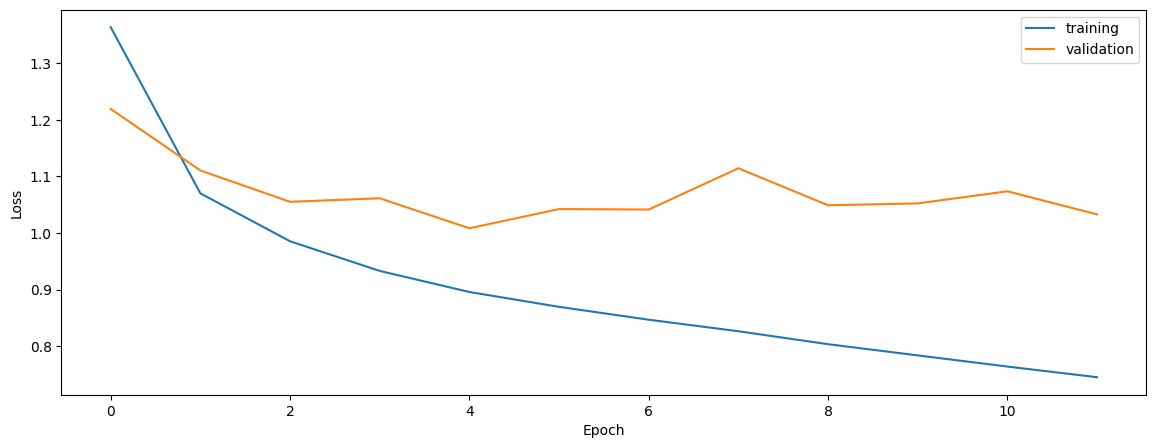

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6486529405322528
0.6129043838595195
0.6199889886077626


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native


0.5233025251070577
0.5370597568092861
0.46813508577716867


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.5241062676866773
0.5324344185688691
0.4796681979911135


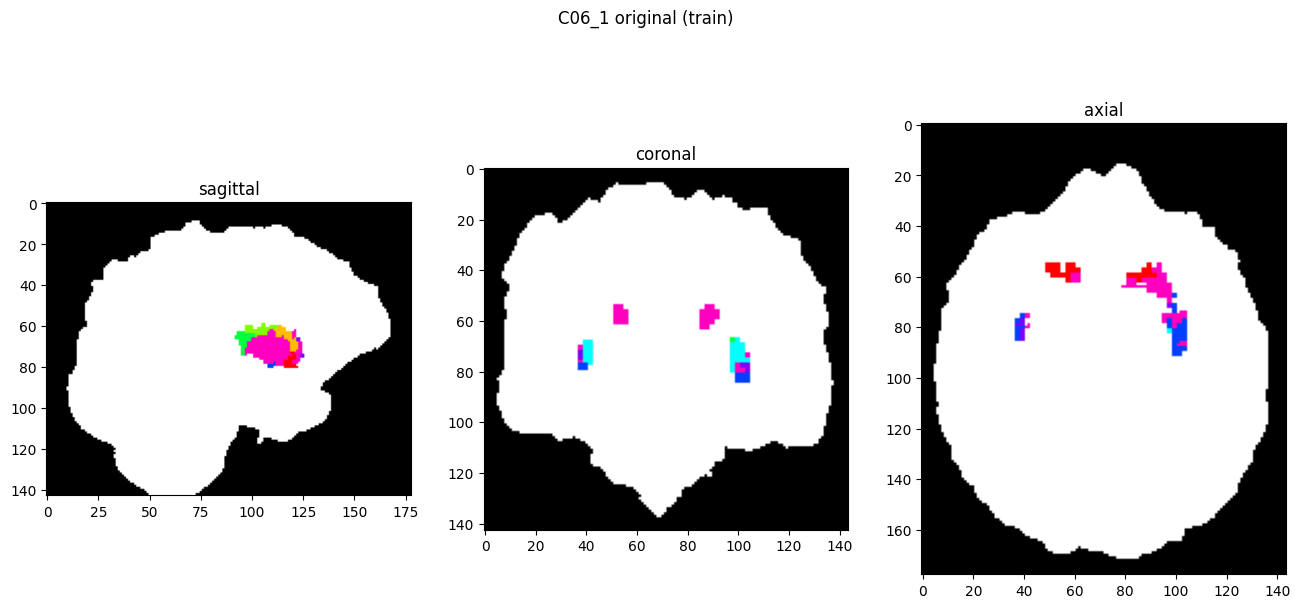

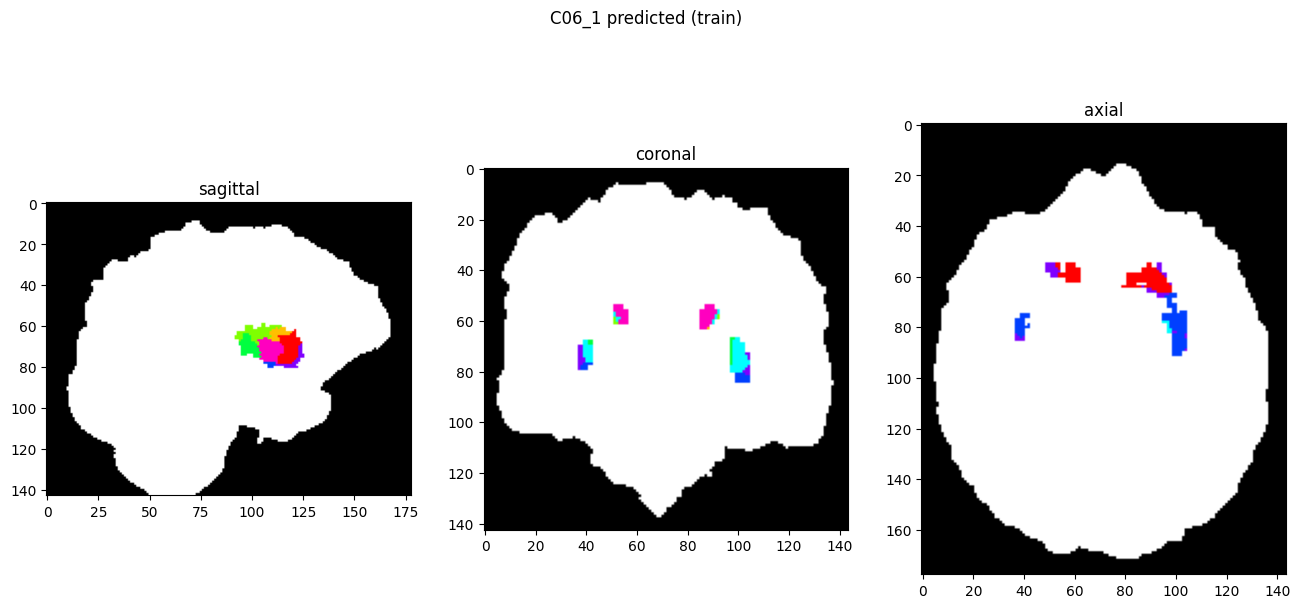

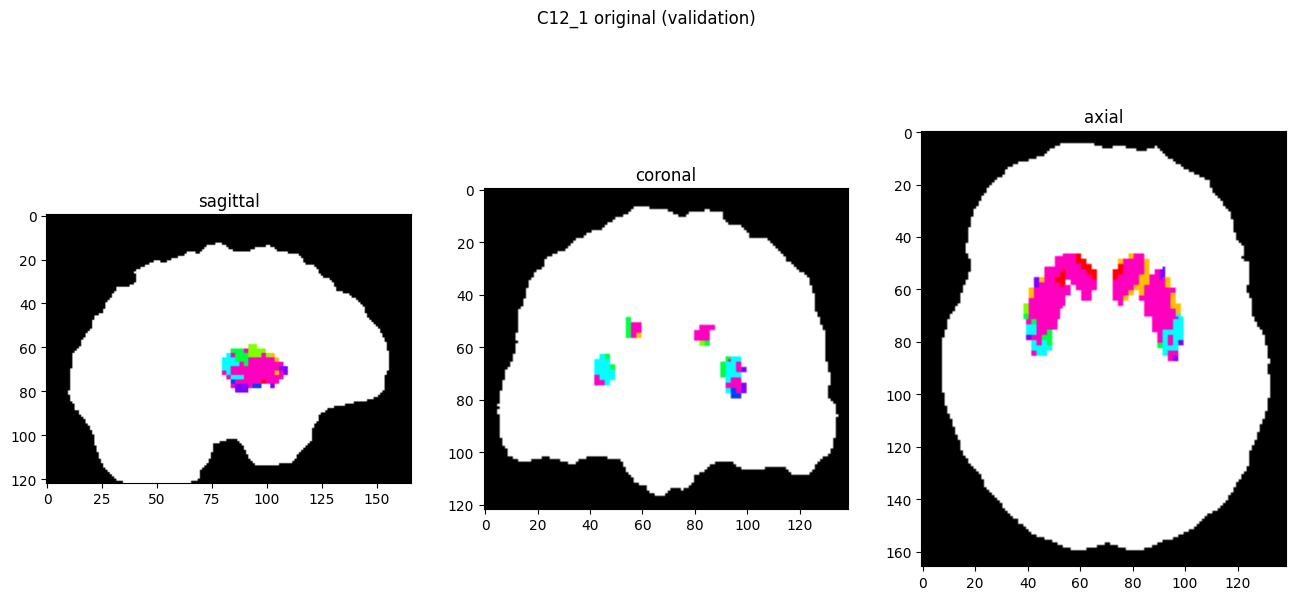

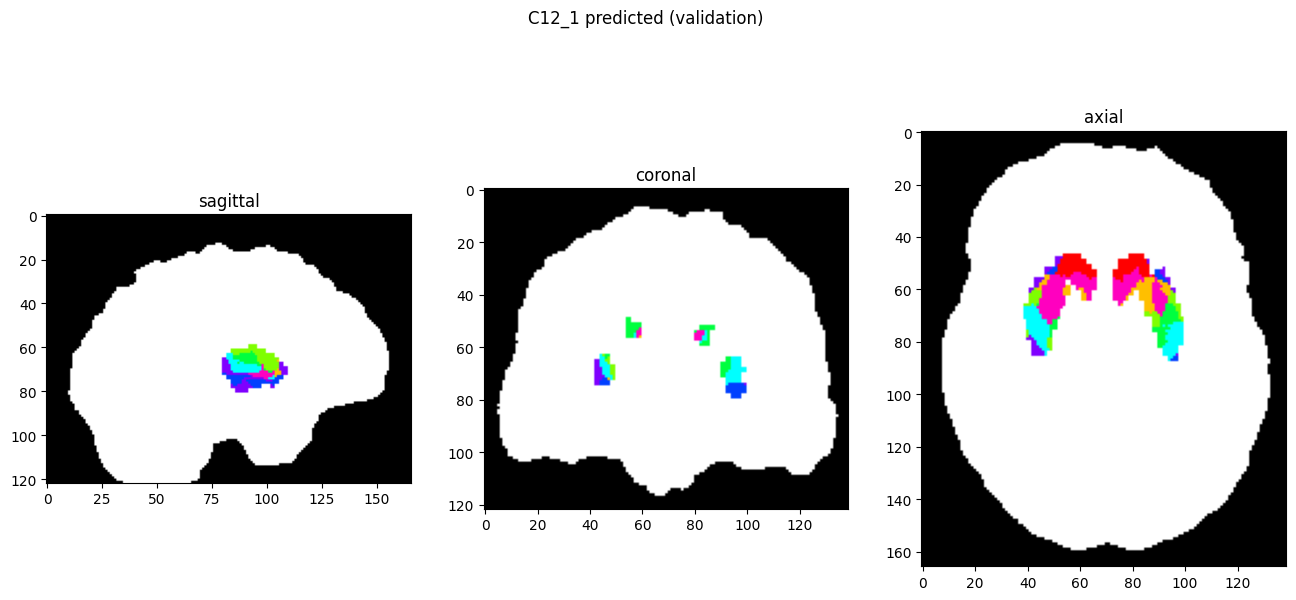

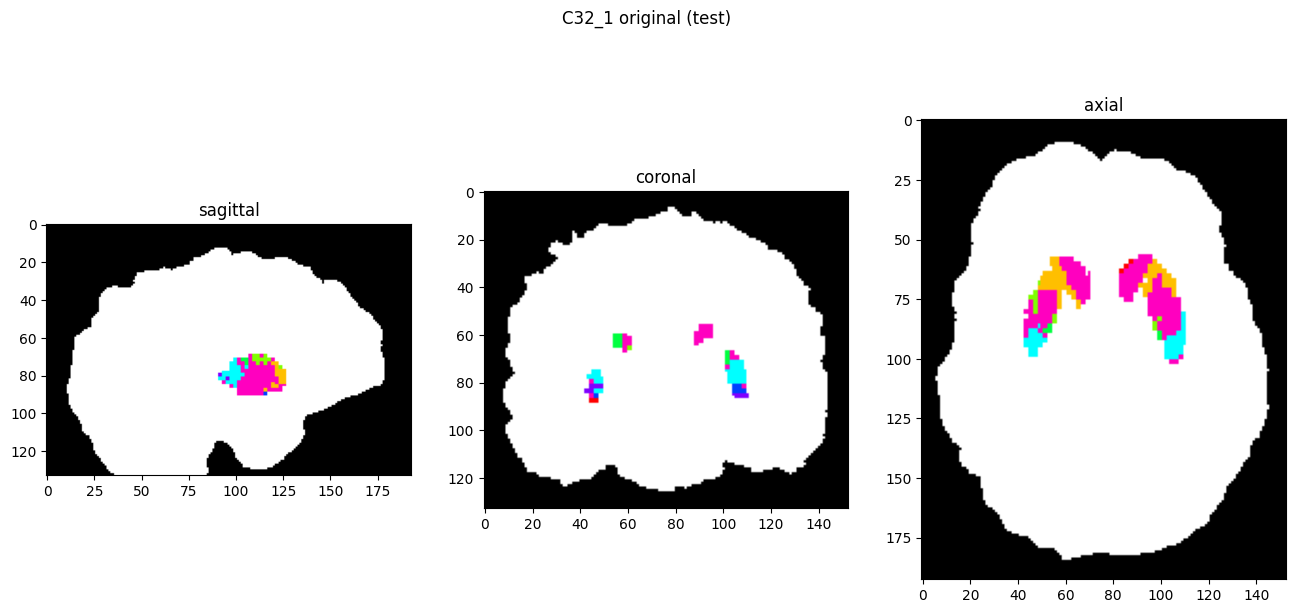

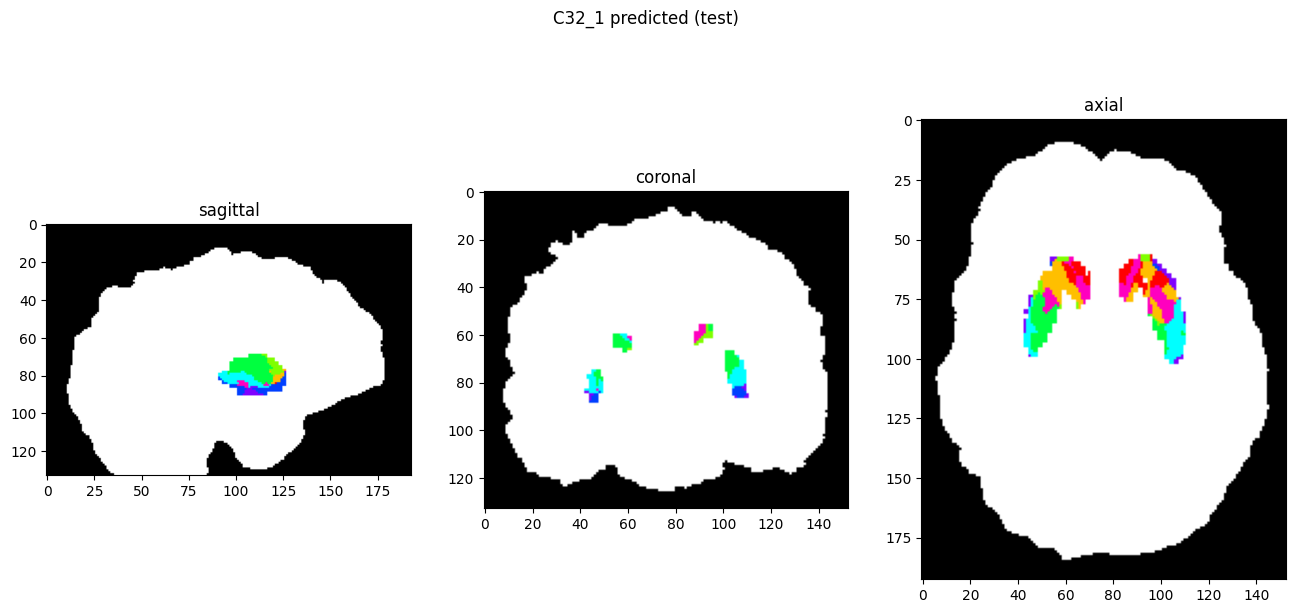

In [10]:
showResults(model, gen, threshold=0)